In [16]:
import os, sys
import numpy as np
import ants
import argparse
import shutil
import logging
import subprocess
import tqdm
import matplotlib.pyplot as plt 

### Testing must inclide check on:
1. Nan and Infifnite values
2. int in labels
3. Different to parent folder
4. Equal orientation to parent folder
5. Visual inspection on one modality

In [24]:
parent_folder = '1_reg'
current_folder = '4b_n4'

In [26]:
len(os.listdir('/anvar/public_datasets/preproc_study/gbm/4d_susan'))

58

In [29]:
len(os.listdir('/anvar/public_datasets/preproc_study/bgpd/4a_resamp'))

181

In [31]:
len(os.listdir('/anvar/public_datasets/preproc_study/bgpd/'))

FileNotFoundError: [Errno 2] No such file or directory: '/anvar/public_datasets/preproc_study/bgpd/1_reg'

### Saving images

In [ ]:
import tqdm
path = '4d_susan'

print('/home/kate/projects/qc_preprocessing/{}_gbm/'.format(path))
os.makedirs('/home/kate/projects/qc_preprocessing/{}_gbm/'.format(path), exist_ok = True)

def plot_qc(image, mask, patient_id):
    fig, axs = plt.subplots(3,3,figsize=(12,12))
    idx = np.argsort(mask.sum(axis=(0,1)))[-3:]
    for i in range(3):
        axs[i, 0].imshow(image[..., idx[i]], cmap='gray')
        axs[i, 1].imshow(mask[..., idx[i]], cmap='gray')
        axs[i, 2].imshow(image[..., idx[i]]+200*mask[..., idx[i]], cmap='gray')
    axs[0,0].set_title(patient_id)
    plt.tight_layout()
    plt.savefig(f'/home/kate/projects/qc_preprocessing/{path}_gbm/{patient_id}.png', dpi=300)
    plt.plot()
    plt.close(fig)

output = '/anvar/public_datasets/preproc_study/gbm/{}/'.format(path)

for patient in tqdm.tqdm(os.listdir(output)):
    try:
        im = ants.image_read(output + patient +'/FLAIR.nii.gz')
        mask = ants.image_read(output + patient +'/CT1_SEG.nii.gz')
        plot_qc(im, mask, patient_id=str(patient))
    except Exception as e:
        print(e, patient)

  0%|          | 0/88 [00:00<?, ?it/s]

/home/kate/projects/qc_preprocessing/4d_susan_gbm/


  1%|          | 1/88 [00:02<03:53,  2.69s/it]

### Old with Invertion

In [2]:
os.listdir('/anvar/public_datasets/preproc_study/gbm/')

['dicom',
 'orig',
 'backlog',
 '4a_resamp',
 'folders_description.md',
 'meta.csv',
 '1_reg',
 'orig_ss_indiv']

In [5]:
os.listdir('/anvar/public_datasets/preproc_study/gbm/orig/TCGA-76-6661')

['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz', 'CT1_SEG.nii.gz', 'CT1.nii.gz']

In [10]:
ants.image_read('/anvar/public_datasets/preproc_study/gbm/1_reg/' + 'TCGA-76-6661/CT1_SEG.nii.gz')

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (16, 256, 256)
	 Spacing    : (7.5, 0.9375, 0.9375)
	 Origin     : (-78.2882, 100.7926, -82.6913)
	 Direction  : [ 0.9977  0.0677  0.      0.0677 -0.9977  0.      0.      0.      1.    ]

In [14]:
ants.image_read('/anvar/public_datasets/preproc_study/gbm/backlog/1_reg/' + 'TCGA-76-6661/CT1_SEG.nii.gz')

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (16, 256, 256)
	 Spacing    : (7.5, 0.9375, 0.9375)
	 Origin     : (-62.0927, -137.7207, -82.6913)
	 Direction  : [ 0.9977 -0.0677  0.      0.0677  0.9977  0.      0.      0.      1.    ]

In [11]:
ants.image_read('/anvar/public_datasets/preproc_study/gbm/orig/' + 'TCGA-76-6661/CT1_SEG.nii.gz')

ANTsImage (AIL)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 256, 16)
	 Spacing    : (0.9375, 0.9375, 7.5)
	 Origin     : (50.1489, -130.0993, -82.6913)
	 Direction  : [-0.0677  0.     -0.9977  0.9977 -0.     -0.0677  0.      1.      0.    ]

In [12]:
ants.image_read('/anvar/public_datasets/preproc_study/gbm/4a_resamp/' + 'TCGA-76-6661/CT1_SEG.nii.gz')

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (120, 240, 240)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-78.2882, 100.7926, -82.6913)
	 Direction  : [ 0.9977  0.0677  0.      0.0677 -0.9977  0.      0.      0.      1.    ]

In [15]:
def pred_invert_resample_classes(data, path_to_orig, path_to_resampled):

    # gbm and lgg
        data = data.transpose(0,3,2,1).astype('float32')

        old_orig_ct1 = ants.image_read(path_to_resampled)
        new_orig_ct1 = ants.image_read(path_to_orig)

        old_like_ch_0 = old_orig_ct1.new_image_like(data[0])
        old_like_ch_1 = old_orig_ct1.new_image_like(data[1])
        old_like_ch_2 = old_orig_ct1.new_image_like(data[2])

        new_img_0 = ants.resample_image(old_like_ch_0, new_orig_ct1.spacing, False, 0)
        new_img_1 = ants.resample_image(old_like_ch_1, new_orig_ct1.spacing, False, 0)
        new_img_2 = ants.resample_image(old_like_ch_2, new_orig_ct1.spacing, False, 0)

        new_img_shape =  new_img_2.numpy().shape

        new_array = np.zeros(tuple([3] + list(new_img_shape)), dtype='float16')
        new_array[0] = new_img_0.numpy()
        new_array[1] = new_img_1.numpy()
        new_array[2] = new_img_2.numpy()
        output_file = new_array.transpose(0,3,2,1).astype('float16')
        return (output_file)

In [1108]:
os.listdir('/anvar/public_datasets/preproc_study/gbm/inference/6_hist/')

['predictions_best_epoch=85-dice_mean=65_99_task=31.0_fold=0_tta',
 'metrics_gbm_6_histogram_fold_2_fold-2.csv',
 'predictions_best_epoch=84-dice_mean=64_34_task=31.2_fold=2_tta',
 'metrics_gbm_6_histogram_fold_0_fold-0.csv',
 'predictions_best_epoch=84-dice_mean=66_80_task=31.1_fold=1_tta']

In [1120]:
len(os.listdir('/anvar/public_datasets/preproc_study/gbm/inference/6_hist/predictions_best_epoch=84-dice_mean=64_34_task=31.2_fold=2_tta'))

99

In [ ]:
len(os.listdir('/anvar/public_datasets/preproc_study/gbm/inference/6_hist/predictions_best_epoch=85-dice_mean=65_99_task=31.0_fold=0_tta'))

In [ ]:
len(os.listdir('/anvar/public_datasets/preproc_study/gbm/inference/6_hist/predictions_best_epoch=84-dice_mean=66_80_task=31.1_fold=1_tta'))

In [1102]:
root = Path('/anvar/public_datasets/preproc_study/gbm/inference/6_hist/predictions_best_epoch=84-dice_mean=64_34_task=31.2_fold=2_tta')

for parent_folder, _, files in os.walk(root):
    for file in files:
        file_path = root / parent_folder / file
        x = np.load(file_path)
        file_path.unlink()
        np.savez_compressed(file_path, x.astype('float16'))

In [1101]:
root = Path('/anvar/public_datasets/preproc_study/gbm/inference/6_hist/predictions_best_epoch=84-dice_mean=66_80_task=31.1_fold=1_tta')

for parent_folder, _, files in os.walk(root):
    for file in files:
        file_path = root / parent_folder / file
        x = np.load(file_path)
        file_path.unlink()
        np.savez_compressed(file_path, x.astype('float16'))

In [1103]:
import os
root = Path('/anvar/public_datasets/preproc_study/gbm/inference/6_hist/predictions_best_epoch=85-dice_mean=65_99_task=31.0_fold=0_tta')

for parent_folder, _, files in os.walk(root):
    for file in files:
        file_path = root / parent_folder / file
        x = np.load(file_path)
        file_path.unlink()
        np.savez_compressed(file_path, x.astype('float16'))

AttributeError: 'NpzFile' object has no attribute 'astype'

In [1097]:
os.listdir('/anvar/public_datasets/preproc_study/gbm/inference/6_hist/predictions_best_epoch=85-dice_mean=65_99_task=31.0_fold=0_tta')

['TCGA-02-0027.npy',
 'TCGA-06-0139.npy',
 'TCGA-19-2631.npy',
 'TCGA-06-0240.npy',
 'TCGA-02-0069.npy',
 'TCGA-14-1825.npy',
 'TCGA-06-5408.npy',
 'TCGA-06-5413.npy',
 'TCGA-12-0776.npy',
 'TCGA-06-1802.npy',
 'TCGA-19-1789.npy',
 'TCGA-76-6282.npy',
 'TCGA-12-1094.npy',
 'TCGA-06-0158.npy',
 'TCGA-06-0138.npy',
 'TCGA-19-2624.npy',
 'TCGA-02-0087.npy',
 'TCGA-76-4934.npy',
 'TCGA-02-0009.npy',
 'TCGA-06-0646.npy',
 'TCGA-06-0122.npy',
 'TCGA-02-0059.npy',
 'TCGA-02-0116.npy',
 'TCGA-06-0137.npy',
 'TCGA-06-1084.npy',
 'TCGA-76-6193.npy',
 'TCGA-02-0086.npy',
 'TCGA-06-0162.npy',
 'TCGA-76-4932.npy',
 'TCGA-76-6191.npy',
 'TCGA-02-0070.npy',
 'TCGA-06-0164.npy',
 'TCGA-12-1098.npy',
 'TCGA-02-0068.npy',
 'TCGA-08-0359.npy',
 'TCGA-02-0034.npy',
 'TCGA-06-0149.npy',
 'TCGA-76-6662.npy',
 'TCGA-76-6657.npy',
 'TCGA-08-0360.npy',
 'TCGA-06-0154.npy',
 'TCGA-06-0187.npy',
 'TCGA-06-0238.npy',
 'TCGA-06-0190.npy',
 'TCGA-06-0119.npy',
 'TCGA-76-6663.npy',
 'TCGA-08-0390.npy',
 'TCGA-06-638

In [1092]:
os.listdir('/anvar/public_datasets/preproc_study/gbm/inference/native_space/6_hist/fold=0')

[]

In [1047]:
folder = '/anvar/public_datasets/preproc_study/gbm/inference/3b_n4/'
for i in os.listdir(folder):
    try:
        print(len(os.listdir(folder +i )))
    except:
        pass

102
102
102


In [235]:
def calculate_z_score(img):
    """ Calculates Z-score normalisation over ants.img and returns new image"""
    
    if type(img) is str:
        # Read images if input is pathlike
        img = ants.image_read(img)
        
    img_z = (img.numpy() - img.numpy().mean())/img.numpy().std()
    new_img = img.new_image_like(img_z)
    return new_img

def rigid_reg(fixed, moving):
    """Rigidly register `moving` image onto `fixed` image and apply resulting transformation on `mask`.
    Returns mask in `fixed` resolution."""
    
    if type(fixed) is str:
        # Read images if input is pathlike
        fixed = ants.image_read(fixed)
        moving = ants.image_read(moving)
    
    # Compute registration if input is ants.image
    res = ants.registration(fixed=fixed, moving=moving,
                            type_of_transform='Rigid')
    
    new_img = ants.apply_transforms(fixed, moving,
                                    transformlist = res['fwdtransforms'][0])
    return new_img

def hdbet_fast(src_path, dst_path):
    command = ["hd-bet", "-i", src_path, "-o", dst_path, "-device", "cpu", "-mode", "fast", "-tta", "0"]
    subprocess.call(command)
    return

def hdbet(src_path, dst_path):
    command = ["hd-bet", "-i", src_path, "-o", dst_path, "-device", "cpu"]
    subprocess.call(command)
    return

In [293]:
from glob import glob
import ants 

output = '/anvar/public_datasets/preproc_study/gbm/1_z_score/'
path = '/anvar/public_datasets/preproc_study/gbm/orig/'
movingfilenames = ['T1.nii.gz', 'FLAIR.nii.gz', 'T2.nii.gz']
fixedfilename = 'CT1.nii.gz'

subjects_paths = [f.path for f in os.scandir(path) if f.is_dir()]
subjects = [f.split('/')[-1] for f in subjects_paths ]

for subject in ['TCGA-06-0646']:
    # Creating folder to save subject data
#     os.makedirs(output + subject + '/', exist_ok=True)
    try:
#         os.makedirs(output + subject + '/')
        img_fixed = glob(path + subject + '/' + fixedfilename)[0]

        for name in movingfilenames:
            img_moving = glob(path + subject + '/' + name)[0]
            # Image registration
            registered_img = rigid_reg(img_fixed, img_moving)
            # Z-score individual calculation
            registered_img_z = calculate_z_score(registered_img)
            ants.image_write(registered_img_z, output + subject + '/' + name , ri=False);

        img_fixed_z = calculate_z_score(img_fixed)
        ants.image_write(img_fixed_z, output + subject + '/' + fixedfilename , ri=False);
    except:
        pass

Exception Object caught: 

itk::ExceptionObject (0x55f1c2940690)
Location: "unknown" 
File: /build100/ANTsPy/itksource/Modules/Core/Common/include/itkImageBase.hxx
Line: 308
Description: itk::ERROR: itk::ERROR: Image(0x55f17f977320): itk::ImageBase::CopyInformation() cannot cast PKN3itk10DataObjectE to PKN3itk9ImageBaseILj4EEE




In [295]:
os.listdir('/anvar/public_datasets/preproc_study/gbm/orig/TCGA-06-0646/CT1a.nii.gz')

['T2.nii.gz',
 'FLAIR.nii.gz',
 'T1.nii.gz',
 'CT1_SEG.nii.gz',
 'CT1a.nii.gz',
 'CT1.nii.gz']

In [298]:
ants.image_read('/anvar/public_datasets/preproc_study/gbm/orig/TCGA-08-0355/CT1a.nii.gz')

ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (512, 512, 72, 2)
	 Spacing    : (0.4688, 0.4688, 2.5, 3.0542)
	 Origin     : (-119.192, 95.7908, -58.339, 0.0)
	 Direction  : [ 1.  0.  0.  0.  0. -1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.]

In [ ]:
ants.image_read('/anvar/public_datasets/preproc_study/gbm/orig/TCGA-06-0646/CT1a.nii.gz')

In [284]:
fixed = ants.image_read(img_fixed)
moving = ants.image_read(img_moving)
# Compute registration if input is ants.image
res = ants.registration(fixed=fixed, moving=moving,
                            type_of_transform='Rigid')
    
# new_img = ants.apply_transforms(img_fixed, img_moving,
#                                     transformlist = res['fwdtransforms'][0])

Exception Object caught: 

itk::ExceptionObject (0x55f1ac4a0fc0)
Location: "unknown" 
File: /build100/ANTsPy/itksource/Modules/Core/Common/include/itkImageBase.hxx
Line: 308
Description: itk::ERROR: itk::ERROR: Image(0x55f1ac49f640): itk::ImageBase::CopyInformation() cannot cast PKN3itk10DataObjectE to PKN3itk9ImageBaseILj4EEE




In [291]:
ants.plot(ants.image_read('/anvar/public_datasets/preproc_study/gbm/orig/TCGA-06-0646/CT1_SEG.nii.gz'))

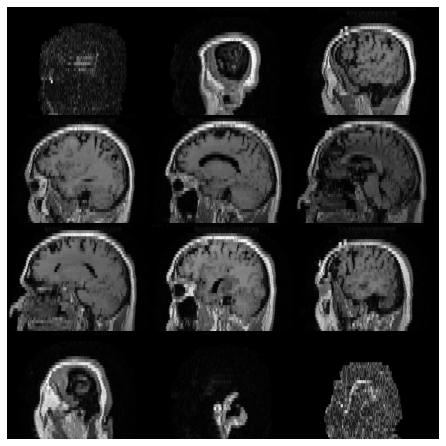

In [286]:
ants.plot(img_moving)

## Copy `seg` files:

In [109]:
basedir = '/anvar/public_datasets/preproc_study/gbm/orig/'

In [113]:
 os.listdir('/anvar/public_datasets/preproc_study/gbm/1_z_score/TCGA-02-0086')

['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz', 'CT1_SEG.nii.gz', 'CT1.nii.gz']

In [248]:
import shutil
# no acess to read-only folder
for i in os.listdir('/anvar/public_datasets/preproc_study/gbm/orig/'):
#     print(len(os.listdir('/anvar/public_datasets/preproc_study/gbm/1_z_score/' + i )))
#     shutil.copy(basedir + i + '/CT1_SEG.nii.gz', '/anvar/public_datasets/preproc_study/gbm/1_z_score/' + i + '/CT1_SEG.nii.gz',)

5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
1
5
5
5
5


In [299]:
os.listdir('/anvar/public_datasets/preproc_study/gbm/')

['dicom',
 'orig',
 '2_n4',
 '1_z_score',
 'folders_description.md',
 'meta.csv',
 '1_reg']

In [362]:
import shlex, time 
base_command = """sudo cp /anvar/public_datasets/preproc_study/gbm/orig/{subject}/CT1_SEG.nii.gz /anvar/public_datasets/preproc_study/gbm/3_susan_captk/{subject}/CT1_SEG.nii.gz"""
for patient in os.listdir('/anvar/public_datasets/preproc_study/gbm/orig/'):
    print(patient)
    command_to_run = base_command.format(subject = patient)
    command_to_run = shlex.split(command_to_run)
    process = subprocess.Popen(command_to_run,shell=False)
#     time.sleep(1)

/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 479291 is still running

/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468070 is still running



TCGA-02-0086
TCGA-02-0102
TCGA-02-0059


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468072 is still running

/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468074 is still running

/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468076 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-19-2624/CT1_SEG.nii.gz': No such file or directory


TCGA-02-0069
TCGA-19-2624
TCGA-06-0182


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468078 is still running

/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468080 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-08-0360/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468082 is still running

/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468084 is still running



TCGA-08-0360
TCGA-02-0006
TCGA-19-2631
TCGA-12-1094


cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-19-2631/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468086 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-12-1094/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468088 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-06-2570/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468090 is still running



TCGA-06-2570
TCGA-06-0119
TCGA-06-0145


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468092 is still running

/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468094 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-08-0509/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468096 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-06-5408/CT1_SEG.nii.gz': No such file or directory


TCGA-08-0509
TCGA-06-5408
TCGA-02-0116


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468098 is still running

/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468100 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-06-0188/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468102 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-76-6661/CT1_SEG.nii.gz': No such file or directory


TCGA-06-0188
TCGA-76-6661
TCGA-02-0047


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468104 is still running

/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468106 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-12-3650/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468108 is still running



TCGA-12-3650
TCGA-02-0064
TCGA-14-1825


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468110 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-14-1825/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468112 is still running

/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468114 is still running



TCGA-06-0162
TCGA-02-0033
TCGA-08-0359


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468116 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-08-0359/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468118 is still running

/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468120 is still running



TCGA-02-0054
TCGA-06-0184
TCGA-12-1601
TCGA-06-5413


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468122 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-12-1601/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468124 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-06-5413/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468126 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-76-6191/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468128 is still running



TCGA-76-6191
TCGA-02-0075
TCGA-06-0177


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468130 is still running

/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468132 is still running

/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468134 is still running



TCGA-06-0154
TCGA-06-0179
TCGA-19-5951


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468136 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-19-5951/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468138 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-12-1598/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468140 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-12-0616/CT1_SEG.nii.gz': No such file or directory


TCGA-12-1598
TCGA-12-0616
TCGA-02-0070


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468142 is still running

/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468144 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-06-1084/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468146 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-12-0829/CT1_SEG.nii.gz': No such file or directory


TCGA-06-1084
TCGA-12-0829
TCGA-76-4932


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468148 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-76-4932/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468150 is still running

/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468152 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-76-6282/CT1_SEG.nii.gz': No such file or directory


TCGA-02-0068
TCGA-76-6282
TCGA-08-0385
TCGA-12-1098


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468154 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-08-0385/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468156 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-12-1098/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468158 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-08-0512/CT1_SEG.nii.gz': No such file or directory


TCGA-08-0512
TCGA-08-0389
TCGA-14-1794


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468160 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-08-0389/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468162 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-14-1794/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468164 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-19-1789/CT1_SEG.nii.gz': No such file or directory


TCGA-19-1789
TCGA-02-0009
TCGA-06-0122


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468166 is still running

/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468168 is still running

/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468170 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-08-0355/CT1_SEG.nii.gz': No such file or directory


TCGA-08-0355
TCGA-06-6389
TCGA-06-0190
TCGA-06-0192


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468172 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-06-6389/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468174 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-06-0190/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468176 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-06-0192/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468178 is still running

/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468180 is still running



TCGA-02-0027
TCGA-06-0137
TCGA-12-0776


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468182 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-12-0776/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468184 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-76-6657/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468186 is still running



TCGA-76-6657
TCGA-06-0176
TCGA-08-0356


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468188 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-08-0356/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468190 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-76-6662/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468192 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-08-0522/CT1_SEG.nii.gz': No such file or directory


TCGA-76-6662
TCGA-08-0522
TCGA-06-1802


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468194 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-06-1802/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468196 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-19-5960/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468198 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-08-0390/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468200 is still running



TCGA-19-5960
TCGA-08-0390
TCGA-14-1456
TCGA-06-0158


cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-14-1456/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468202 is still running

/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468204 is still running

/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468220 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-06-0238/CT1_SEG.nii.gz': No such file or directory


TCGA-06-0139
TCGA-06-0238
TCGA-76-4935


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468222 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-76-4935/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468224 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-14-3477/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468226 is still running



TCGA-14-3477
TCGA-02-0106
TCGA-06-0644


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468228 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-06-0644/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468230 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-19-0963/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468232 is still running



TCGA-19-0963
TCGA-06-0187
TCGA-76-6664


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468234 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-76-6664/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468236 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-76-6663/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468238 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-76-6285/CT1_SEG.nii.gz': No such file or directory


TCGA-76-6663
TCGA-76-6285
TCGA-76-4934


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468240 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-76-4934/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468242 is still running

/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468244 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-08-0392/CT1_SEG.nii.gz': No such file or directory


TCGA-02-0087
TCGA-08-0392
TCGA-02-0085


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468246 is still running

/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468248 is still running

/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468250 is still running



TCGA-06-0185
TCGA-06-0130
TCGA-06-0240


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468252 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-06-0240/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468254 is still running

/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468256 is still running



TCGA-02-0034
TCGA-06-0149
TCGA-02-0011


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468258 is still running

/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468260 is still running

/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468262 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-76-6280/CT1_SEG.nii.gz': No such file or directory


TCGA-06-0138
TCGA-76-6280
TCGA-19-5954


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468264 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-19-5954/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468266 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-76-6193/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468268 is still running



TCGA-76-6193
TCGA-06-0164
TCGA-06-5417


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468270 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-06-5417/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468273 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-19-5958/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468365 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-76-6656/CT1_SEG.nii.gz': No such file or directory


TCGA-19-5958
TCGA-76-6656
TCGA-06-0646


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468632 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-06-0646/CT1_SEG.nii.gz': No such file or directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1468906 is still running

/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1469198 is still running



TCGA-02-0046
TCGA-06-0142
TCGA-02-0037
TCGA-08-0520


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1469508 is still running

/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 1469784 is still running

cp: cannot create regular file '/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-08-0520/CT1_SEG.nii.gz'

## Read files

In [332]:
output = '/anvar/public_datasets/preproc_study/gbm/3_susan/'
len(os.listdir(output))

106

In [230]:
os.listdir('/anvar/public_datasets/preproc_study/gbm/1_z_score/TCGA-02-0086')

['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz', 'CT1_SEG.nii.gz', 'CT1.nii.gz']

In [227]:
ants.image_read('/anvar/public_datasets/preproc_study/gbm/1_z_score/' + 'TCGA-12-1094/CT1.nii.gz')

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 256, 22)
	 Spacing    : (0.9375, 0.9375, 6.5)
	 Origin     : (-120.0, 134.2624, -59.2019)
	 Direction  : [ 1.e+00  0.e+00  0.e+00  0.e+00 -1.e+00 -8.e-04  0.e+00 -8.e-04  1.e+00]

In [206]:
os.listdir('/anvar/public_datasets/preproc_study/gbm/orig/TCGA-06-1802')

['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz', 'CT1_SEG.nii.gz', 'CT1.nii.gz']

In [311]:
# os.mkdir('/home/kate/projects/qc_preprocessing/2_n4_gbm/')

In [350]:
# os.mkdir('/anvar/public_datasets/preproc_study/gbm/3_susan_captk/')

In [356]:
os.listdir('/anvar/public_datasets/preproc_study/gbm/3_susan_captk/TCGA-02-0006')

['T2.nii.gz',
 'FLAIR.nii.gz',
 'T1.nii.gz',
 'CT1_n4.nii.gz',
 'CT1.nii.gz',
 'T2_n4.nii.gz',
 'T1_n4.nii.gz',
 'FLAIR_n4.nii.gz']

In [ ]:
'/anvar/public_datasets/preproc_study/gbm/1_reg/logging.txt'

In [349]:
# os.mkdir('/home/kate/projects/qc_preprocessing/3_susan_captk_gbm/')

In [343]:
os.listdir('/anvar/public_datasets/preproc_study/gbm/3_susan/TCGA-02-0046')

['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz', 'CT1_SEG.nii.gz']

In [370]:
# os.mkdir('/home/kate/projects/qc_preprocessing/5_atlas_gbm/')

In [330]:
import tqdm
path = '1_reg'

print('/home/kate/projects/qc_preprocessing/{}_schw/'.format(path))
os.makedirs('/home/kate/projects/qc_preprocessing/{}_schw/'.format(path), exist_ok = True)

def plot_qc(image, mask, patient_id):
    fig, axs = plt.subplots(3,3,figsize=(12,12))
    idx = np.argsort(mask.sum(axis=(0,1)))[-3:]
    for i in range(3):
        axs[i, 0].imshow(image[..., idx[i]], cmap='gray')
        axs[i, 1].imshow(mask[..., idx[i]], cmap='gray')
        axs[i, 2].imshow(image[..., idx[i]]+200*mask[..., idx[i]], cmap='gray')
    axs[0,0].set_title(patient_id)
    plt.tight_layout()
    plt.savefig(f'/home/kate/projects/qc_preprocessing/{path}_schw/{patient_id}.png', dpi=300)
    plt.plot()
    plt.close(fig)

output = '/anvar/public_datasets/preproc_study/schw/{}/'.format(path)

for patient in tqdm.tqdm(os.listdir(output)):
    try:
        im = ants.image_read(output + patient +'/T1.nii.gz')
        mask = ants.image_read(output + patient +'/T1_SEG.nii.gz')
        plot_qc(im, mask, patient_id=str(patient))
    except Exception as e:
        print(e, patient)

  0%|          | 0/243 [00:00<?, ?it/s]

/home/kate/projects/qc_preprocessing/1_reg_schw/


 91%|█████████ | 220/243 [28:01<02:49,  7.37s/it]

File /anvar/public_datasets/preproc_study/schw/1_reg/logging.txt/T1.nii.gz does not exist! logging.txt


100%|██████████| 243/243 [31:01<00:00,  7.66s/it]


In [90]:
!which pip

/home/kate/miniconda3/bin/pip


In [269]:
os.listdir('/anvar/public_datasets/preproc_study/gbm/orig/TCGA-06-0646/')

['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz', 'CT1_SEG.nii.gz', 'CT1.nii.gz']

In [ ]:
#scp -r notebook_airi:/home/kate/projects/qc_preprocessing/7a_resamp_gbm/ /mnt/d/

## Check denoising

In [43]:
folder = '/anvar/public_datasets/preproc_study/gbm/3b_n4/TCGA-06-0646/'
os.listdir(folder)

['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz', 'CT1_SEG.nii.gz', 'CT1.nii.gz']

In [282]:
ants.image_read('/anvar/public_datasets/preproc_study/gbm/2a_interp/TCGA-02-0033/FLAIR.nii.gz').numpy().dtype

dtype('float32')

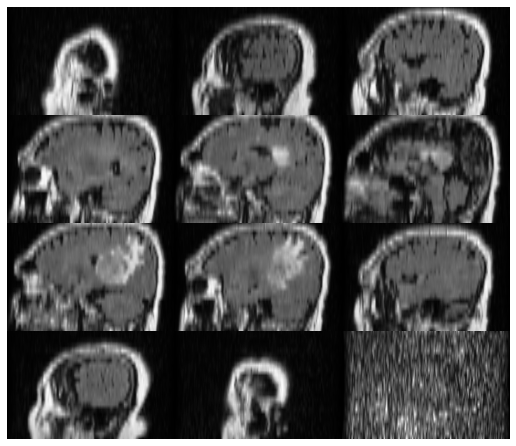

In [283]:
ants.plot(ants.image_read('/anvar/public_datasets/preproc_study/gbm/2a_interp/TCGA-02-0033/FLAIR.nii.gz'))

## Check interpretation

In [84]:
atlas

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (240, 240, 155)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (120.0, 129.0, -68.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [88]:
test1 = ants.image_read('/anvar/public_datasets/preproc_study/gbm/3a_atlas/TCGA-06-0154/CT1.nii.gz')
test1 

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (240, 240, 155)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (120.0, 129.0, -68.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

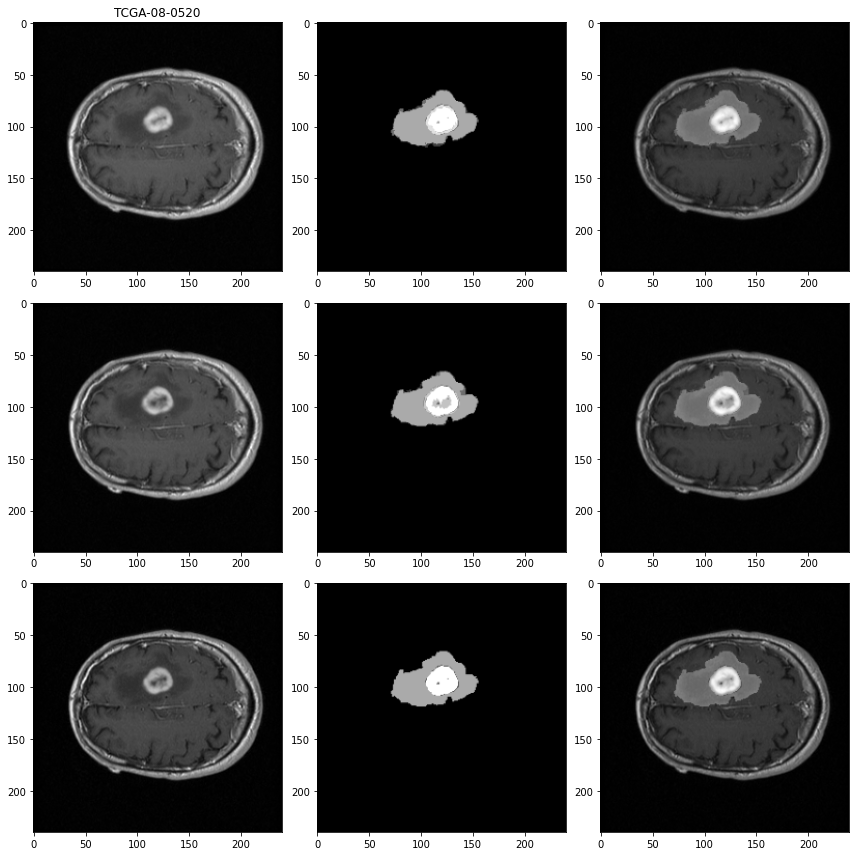

In [82]:
def plot_qc(image, mask, patient_id):
    fig, axs = plt.subplots(3,3,figsize=(12,12))
    idx = np.argsort(mask.sum(axis=(0,1)))[-3:]
    for i in range(3):
        axs[i, 0].imshow(image[..., idx[i]], cmap='gray')
        axs[i, 1].imshow(mask[..., idx[i]], cmap='gray')
        axs[i, 2].imshow(image[..., idx[i]]+200*mask[..., idx[i]], cmap='gray')
    axs[0,0].set_title(patient_id)
    plt.tight_layout()
#     plt.savefig(f'/home/kate/projects/qc_preprocessing/{path}_gbm/{patient_id}.png', dpi=300)
    plt.plot()
#     plt.close(fig)


im = ants.image_read('/anvar/public_datasets/preproc_study/gbm/2a_interp/TCGA-06-0154' +'/CT1.nii.gz')
mask = ants.image_read('/anvar/public_datasets/preproc_study/gbm/2a_interp/TCGA-06-0154'  +'/CT1_SEG.nii.gz')
plot_qc(im, mask, patient_id=str(patient))

##  HD-BET

In [99]:
test1 = ants.image_read('/anvar/public_datasets/preproc_study/gbm/1_reg/TCGA-06-0154/CT1.nii.gz')
test2 = ants.image_read('/anvar/public_datasets/preproc_study/gbm/orig/TCGA-06-0646/CT1.nii.gz')

atlas1 = ants.image_read('./utils/MNI152_T1_1mm_brain.nii.gz')
atlas2 = ants.image_read('./utils/sri24_T1.nii')

In [124]:
!ls

1_reg.out      2a_interp.py    3a_atlas.out  3c_n4_susan.sh   CT1.nii.gz
1_reg.py       2b_n4.sh        3a_atlas.py   5_ss.py	      test_gbm.ipynb
2a_interp.out  2c_n4_susan.sh  3b_n4.sh      CT1_mask.nii.gz  utils


In [122]:
def hdbet_mask(src_path, dst_path, mask_path):
    command = ["hd-bet", "-i", src_path, "-o", dst_path, "-device", "cpu", "-s", "1"]
    subprocess.call(command)
    return

In [123]:
src_path = '/anvar/public_datasets/preproc_study/gbm/1_reg/TCGA-06-0154/CT1.nii.gz'
dst_path = 'CT1.nii.gz'
mask_path = 'CT1_mask.nii.gz'
hdbet_mask(src_path, dst_path, mask_path)


########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /anvar/public_datasets/preproc_study/gbm/1_reg/TCGA-06-0154/CT1.nii.gz
preprocessing...
image shape after preprocessing:  (112, 160, 160)
prediction (CNN id)...
0
1
2
3
4
running postprocessing... 
exporting segmentation...


In [120]:
!hd-bet -h


########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

usage: hd-bet [-h] -i INPUT [-o OUTPUT] [-mode MODE] [-device DEVICE]
              [-tta TTA] [-pp PP] [-s SAVE_MASK]
              [--overwrite_existing OVERWRITE_EXISTING]

optional arguments:
  -h, --help            show this help message and exit
  -i INPUT, --input INPUT
                        input. Can be either a single file name or an input
                        folder. If file: must be nifti (.nii.gz) and can only
                        be 3D. No support for 4d images, use fslsplit to split
                        4d sequences into 3d images. If folder: all files
                        endin

In [103]:
test1.new_image_like(test1.numpy()+1)

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 256, 56)
	 Spacing    : (0.938, 0.938, 3.0)
	 Origin     : (-120.0, 127.0, -90.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [75]:
ants.get_origin(atlas)

(120.0, 129.0, -68.0)

54
55
46


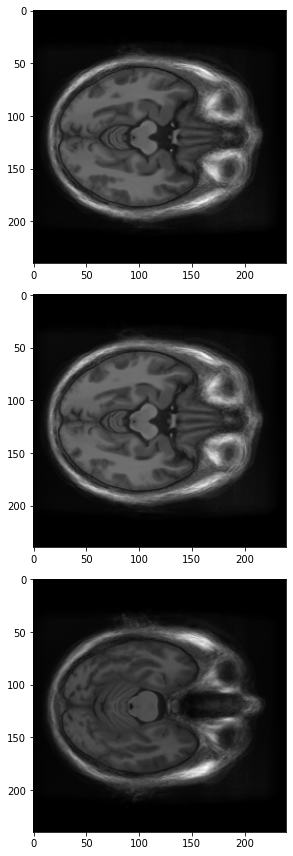

In [73]:
def plot_image(image):
    fig, axs = plt.subplots(3,1,figsize=(12,12))
    idx = np.argsort(image.sum(axis=(0,1)))[-40:]
    for i in range(3):
        print(idx[i])
        axs[i].imshow(image[..., idx[i]], cmap='gray')
    plt.tight_layout()
    plt.plot()

plot_image(atlas)

### Folders check

In [127]:
test_images  = ['TCGA-06-0154','TCGA-06-0646','TCGA-02-0046','TCGA-08-0355']

In [328]:
for folder in os.listdir('/anvar/public_datasets/preproc_study/gbm/'):
    try:
        print(folder)
        for image in test_images:
            print(os.listdir('/anvar/public_datasets/preproc_study/gbm/' + folder + '/' + image))
    except:
        pass

dicom
['T1', 'T2', 'CT1', 'RTSTRUCT', 'FLAIR', 'RTSTRUCT_DICOM']
['T1', 'T2', 'CT1', 'RTSTRUCT', 'FLAIR', 'RTSTRUCT_DICOM']
['T1', 'T2', 'CT1', 'RTSTRUCT', 'FLAIR', 'RTSTRUCT_DICOM']
['T1', 'T2', 'CT1', 'RTSTRUCT', 'FLAIR', 'RTSTRUCT_DICOM']
3a_atlas
['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz', 'CT1_SEG.nii.gz', 'CT1.nii.gz']
['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz', 'CT1_SEG.nii.gz', 'CT1.nii.gz']
['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz', 'CT1_SEG.nii.gz', 'CT1.nii.gz']
['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz', 'CT1_SEG.nii.gz', 'CT1.nii.gz']
orig
['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz', 'CT1_SEG.nii.gz', 'FLAIR_Eq_1.nii.gz', 'CT1.nii.gz']
['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz', 'CT1_SEG.nii.gz', 'CT1.nii.gz']
['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz', 'CT1_SEG.nii.gz', 'CT1.nii.gz']
['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz', 'CT1_SEG.nii.gz', 'CT1.nii.gz']
3b_n4
['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz', 'CT1_SEG.nii.gz', 'CT1.nii.gz']
['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz',

In [327]:
# removing files
import shlex
base_command = """sudo rm /anvar/public_datasets/preproc_study/gbm/1_reg_ss_shared/{subject}/FLAIR_RPI.nii.gz"""
for patient in tqdm.tqdm(os.listdir('/anvar/public_datasets/preproc_study/gbm/2c_n4_susan')):
    print(patient)
    command_to_run = base_command.format(subject = patient)
    command_to_run = shlex.split(command_to_run)
    process = subprocess.Popen(command_to_run,shell=False)

  0%|          | 0/103 [00:00<?, ?it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382212 is still running

  1%|          | 1/103 [00:00<00:16,  6.13it/s]

TCGA-02-0086
TCGA-02-0102


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382214 is still running

  2%|▏         | 2/103 [00:00<00:16,  6.12it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382216 is still running

  3%|▎         | 3/103 [00:00<00:16,  6.11it/s]

TCGA-02-0059
TCGA-02-0069


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382218 is still running

  4%|▍         | 4/103 [00:00<00:16,  6.12it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382220 is still running

  5%|▍         | 5/103 [00:00<00:15,  6.13it/s]

TCGA-19-2624
TCGA-06-0182


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382222 is still running

  6%|▌         | 6/103 [00:00<00:15,  6.15it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382224 is still running

  7%|▋         | 7/103 [00:01<00:15,  6.18it/s]

TCGA-08-0360
TCGA-02-0006


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382226 is still running

  8%|▊         | 8/103 [00:01<00:15,  6.18it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382228 is still running

  9%|▊         | 9/103 [00:01<00:15,  6.17it/s]

TCGA-19-2631
TCGA-12-1094


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382230 is still running

 10%|▉         | 10/103 [00:01<00:15,  6.15it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382232 is still running

 11%|█         | 11/103 [00:01<00:14,  6.14it/s]

TCGA-06-2570
TCGA-06-0119


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382234 is still running

 12%|█▏        | 12/103 [00:01<00:14,  6.14it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382236 is still running

 13%|█▎        | 13/103 [00:02<00:14,  6.14it/s]

TCGA-06-0145
TCGA-08-0509


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382238 is still running

 14%|█▎        | 14/103 [00:02<00:14,  6.15it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382240 is still running

 15%|█▍        | 15/103 [00:02<00:14,  6.12it/s]

TCGA-06-5408
TCGA-02-0116


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382242 is still running

 16%|█▌        | 16/103 [00:02<00:14,  6.13it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382244 is still running

 17%|█▋        | 17/103 [00:02<00:14,  6.14it/s]

TCGA-06-0188
TCGA-76-6661


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382246 is still running

 17%|█▋        | 18/103 [00:02<00:13,  6.13it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382248 is still running

 18%|█▊        | 19/103 [00:03<00:13,  6.09it/s]

TCGA-02-0047
TCGA-12-3650


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382250 is still running

 19%|█▉        | 20/103 [00:03<00:13,  6.10it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382252 is still running

 20%|██        | 21/103 [00:03<00:13,  6.11it/s]

TCGA-02-0064
TCGA-14-1825


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382254 is still running

 21%|██▏       | 22/103 [00:03<00:13,  6.12it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382256 is still running

 22%|██▏       | 23/103 [00:03<00:13,  6.10it/s]

TCGA-06-0162
TCGA-02-0033


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382258 is still running

 23%|██▎       | 24/103 [00:03<00:13,  6.05it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382260 is still running

 24%|██▍       | 25/103 [00:04<00:12,  6.05it/s]

TCGA-08-0359
TCGA-02-0054


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382262 is still running

 25%|██▌       | 26/103 [00:04<00:12,  6.08it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382264 is still running

 26%|██▌       | 27/103 [00:04<00:12,  5.96it/s]

TCGA-06-0184
TCGA-12-1601


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382266 is still running

 27%|██▋       | 28/103 [00:04<00:12,  5.99it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382268 is still running

 28%|██▊       | 29/103 [00:04<00:12,  5.97it/s]

TCGA-06-5413
TCGA-76-6191


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382270 is still running

 29%|██▉       | 30/103 [00:04<00:12,  5.94it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382272 is still running

 30%|███       | 31/103 [00:05<00:12,  5.99it/s]

TCGA-02-0075
TCGA-06-0177


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382274 is still running

 31%|███       | 32/103 [00:05<00:11,  6.04it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382276 is still running

 32%|███▏      | 33/103 [00:05<00:11,  6.09it/s]

TCGA-06-0154
TCGA-06-0179


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382278 is still running

 33%|███▎      | 34/103 [00:05<00:11,  6.11it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382280 is still running

 34%|███▍      | 35/103 [00:05<00:11,  6.06it/s]

TCGA-19-5951
TCGA-12-1598


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382282 is still running

 35%|███▍      | 36/103 [00:05<00:11,  5.82it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382284 is still running

 36%|███▌      | 37/103 [00:06<00:11,  5.91it/s]

TCGA-12-0616
TCGA-02-0070


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382286 is still running

 37%|███▋      | 38/103 [00:06<00:10,  5.97it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382288 is still running

 38%|███▊      | 39/103 [00:06<00:10,  6.02it/s]

TCGA-06-1084
TCGA-12-0829


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382290 is still running

 39%|███▉      | 40/103 [00:06<00:10,  6.04it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382292 is still running

 40%|███▉      | 41/103 [00:06<00:10,  6.02it/s]

TCGA-76-4932
TCGA-02-0068


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382294 is still running

 41%|████      | 42/103 [00:06<00:10,  5.81it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382296 is still running

 42%|████▏     | 43/103 [00:07<00:10,  5.87it/s]

TCGA-76-6282
TCGA-08-0385


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382298 is still running

 43%|████▎     | 44/103 [00:07<00:10,  5.89it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382300 is still running

 44%|████▎     | 45/103 [00:07<00:09,  5.82it/s]

TCGA-12-1098
TCGA-08-0512


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382302 is still running

 45%|████▍     | 46/103 [00:07<00:09,  5.91it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382304 is still running

 46%|████▌     | 47/103 [00:07<00:09,  5.80it/s]

TCGA-08-0389
TCGA-14-1794


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382306 is still running

 47%|████▋     | 48/103 [00:07<00:09,  5.66it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382308 is still running

 48%|████▊     | 49/103 [00:08<00:09,  5.61it/s]

TCGA-19-1789
TCGA-02-0009


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382310 is still running

 49%|████▊     | 50/103 [00:08<00:09,  5.66it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382312 is still running

 50%|████▉     | 51/103 [00:08<00:09,  5.70it/s]

TCGA-06-0122
TCGA-08-0355


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382314 is still running

 50%|█████     | 52/103 [00:08<00:09,  5.61it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382316 is still running

 51%|█████▏    | 53/103 [00:08<00:08,  5.60it/s]

TCGA-06-6389
TCGA-06-0190


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382318 is still running

 52%|█████▏    | 54/103 [00:09<00:09,  5.37it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382320 is still running

 53%|█████▎    | 55/103 [00:09<00:08,  5.47it/s]

TCGA-06-0192
TCGA-02-0027


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382322 is still running

 54%|█████▍    | 56/103 [00:09<00:08,  5.51it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382324 is still running

 55%|█████▌    | 57/103 [00:09<00:08,  5.38it/s]

TCGA-06-0137
TCGA-12-0776


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382326 is still running

 56%|█████▋    | 58/103 [00:09<00:08,  5.53it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382328 is still running

 57%|█████▋    | 59/103 [00:09<00:07,  5.71it/s]

TCGA-76-6657
TCGA-06-0176


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382330 is still running

 58%|█████▊    | 60/103 [00:10<00:07,  5.82it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382332 is still running

 59%|█████▉    | 61/103 [00:10<00:07,  5.72it/s]

TCGA-08-0356
TCGA-76-6662


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382334 is still running

 60%|██████    | 62/103 [00:10<00:07,  5.73it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382336 is still running

 61%|██████    | 63/103 [00:10<00:06,  5.75it/s]

TCGA-08-0522
TCGA-06-1802


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382338 is still running

 62%|██████▏   | 64/103 [00:10<00:06,  5.64it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382340 is still running

 63%|██████▎   | 65/103 [00:11<00:06,  5.70it/s]

TCGA-19-5960
TCGA-08-0390


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382342 is still running

 64%|██████▍   | 66/103 [00:11<00:06,  5.77it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382344 is still running

 65%|██████▌   | 67/103 [00:11<00:06,  5.70it/s]

TCGA-14-1456
TCGA-06-0158


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382346 is still running

 66%|██████▌   | 68/103 [00:11<00:06,  5.51it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382348 is still running

 67%|██████▋   | 69/103 [00:11<00:06,  5.56it/s]

TCGA-06-0139
TCGA-06-0238


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382350 is still running

 68%|██████▊   | 70/103 [00:11<00:05,  5.62it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382352 is still running

 69%|██████▉   | 71/103 [00:12<00:05,  5.62it/s]

TCGA-76-4935
TCGA-14-3477


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382354 is still running

 70%|██████▉   | 72/103 [00:12<00:05,  5.55it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382356 is still running

 71%|███████   | 73/103 [00:12<00:05,  5.64it/s]

TCGA-02-0106
TCGA-06-0644


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382358 is still running

 72%|███████▏  | 74/103 [00:12<00:05,  5.70it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382360 is still running

 73%|███████▎  | 75/103 [00:12<00:04,  5.76it/s]

TCGA-19-0963
TCGA-06-0187


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382362 is still running

 74%|███████▍  | 76/103 [00:12<00:04,  5.77it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382364 is still running

 75%|███████▍  | 77/103 [00:13<00:04,  5.77it/s]

TCGA-76-6664
TCGA-76-6663


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382366 is still running

 76%|███████▌  | 78/103 [00:13<00:04,  5.87it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382368 is still running

 77%|███████▋  | 79/103 [00:13<00:04,  5.97it/s]

TCGA-76-6285
TCGA-76-4934


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382370 is still running

 78%|███████▊  | 80/103 [00:13<00:03,  6.02it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382372 is still running

 79%|███████▊  | 81/103 [00:13<00:03,  6.03it/s]

TCGA-02-0087
TCGA-08-0392


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382374 is still running

 80%|███████▉  | 82/103 [00:13<00:03,  6.07it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382376 is still running

 81%|████████  | 83/103 [00:14<00:03,  6.11it/s]

TCGA-02-0085
TCGA-06-0185


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382378 is still running

 82%|████████▏ | 84/103 [00:14<00:03,  6.15it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382380 is still running

 83%|████████▎ | 85/103 [00:14<00:02,  6.14it/s]

TCGA-06-0130
TCGA-06-0240


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382382 is still running

 83%|████████▎ | 86/103 [00:14<00:02,  6.10it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382384 is still running

 84%|████████▍ | 87/103 [00:14<00:02,  6.13it/s]

TCGA-02-0034
TCGA-06-0149


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382386 is still running

 85%|████████▌ | 88/103 [00:14<00:02,  6.08it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382388 is still running

 86%|████████▋ | 89/103 [00:15<00:02,  5.69it/s]

TCGA-02-0011


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382390 is still running

 87%|████████▋ | 90/103 [00:15<00:02,  5.49it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382392 is still running

 88%|████████▊ | 91/103 [00:15<00:02,  5.40it/s]

TCGA-06-0138
TCGA-76-6280
TCGA-19-5954


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382394 is still running

 89%|████████▉ | 92/103 [00:15<00:02,  5.29it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382396 is still running

 90%|█████████ | 93/103 [00:15<00:01,  5.48it/s]

TCGA-76-6193
TCGA-06-0164


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382398 is still running

 91%|█████████▏| 94/103 [00:16<00:01,  5.61it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382400 is still running

 92%|█████████▏| 95/103 [00:16<00:01,  5.49it/s]

TCGA-06-5417
TCGA-19-5958


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382402 is still running

 93%|█████████▎| 96/103 [00:16<00:01,  5.60it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382404 is still running

 94%|█████████▍| 97/103 [00:16<00:01,  5.48it/s]

TCGA-76-6656
TCGA-06-0646


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382406 is still running

 95%|█████████▌| 98/103 [00:16<00:00,  5.54it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382408 is still running

 96%|█████████▌| 99/103 [00:16<00:00,  5.66it/s]

TCGA-02-0046
logging.txt


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382410 is still running

 97%|█████████▋| 100/103 [00:17<00:00,  5.77it/s]rm: cannot remove '/anvar/public_datasets/preproc_study/gbm/1_reg_ss_shared/logging.txt/FLAIR_RPI.nii.gz': Not a directory
/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382412 is still running

 98%|█████████▊| 101/103 [00:17<00:00,  5.85it/s]

TCGA-06-0142
TCGA-02-0037


/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382414 is still running

 99%|█████████▉| 102/103 [00:17<00:00,  5.75it/s]/home/kate/miniconda3/lib/python3.9/subprocess.py:1048: ResourceWarning:

subprocess 382416 is still running

100%|██████████| 103/103 [00:17<00:00,  5.85it/s]

TCGA-08-0520


In [174]:
img_new = ants.image_read('/anvar/public_datasets/preproc_study/gbm/' + '3b_n4' + '/' + image +'/' + 'CT1_SEG.nii.gz')
img_old = ants.image_read('/anvar/public_datasets/preproc_study/gbm/' + '3c_n4_susan' + '/' + image +'/' + 'CT1_SEG.nii.gz')
            
np.allclose(img_new.numpy(),img_old.numpy())

True

In [177]:
list_folders =  ['orig', '1_reg', '2a_interp', '2b_n4', '2c_n4_susan', '3a_atlas','3b_n4', '3c_n4_susan']
test_images  = ['TCGA-06-0154','TCGA-06-0646','TCGA-02-0046','TCGA-08-0355']

for i in range(0, len(list_folders)):
    cur_folder = list_folders[i]
    next_folder = list_folders[i + 1]
    
    print(cur_folder, 'vs',  next_folder)
    
    for image in test_images:
        
        for mod in ['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz', 'CT1_SEG.nii.gz', 'CT1.nii.gz']:
            
            img_new = ants.image_read('/anvar/public_datasets/preproc_study/gbm/' + cur_folder + '/' + image +'/' + mod)
            img_old = ants.image_read('/anvar/public_datasets/preproc_study/gbm/' + next_folder + '/' + image +'/' + mod)
            
            try:
                if np.allclose(img_new.numpy(),img_old.numpy()):
                    print('For ', image, mod, cur_folder, next_folder, 'images are the same')
            except Exception as e:
                pass
#                 print(e)

1_reg
2a_interp
2b_n4
For  TCGA-06-0154 CT1_SEG.nii.gz 2a_interp 2b_n4 images are the same
For  TCGA-06-0646 CT1_SEG.nii.gz 2a_interp 2b_n4 images are the same
For  TCGA-02-0046 CT1_SEG.nii.gz 2a_interp 2b_n4 images are the same
For  TCGA-08-0355 CT1_SEG.nii.gz 2a_interp 2b_n4 images are the same
2c_n4_susan
For  TCGA-06-0154 CT1_SEG.nii.gz 2b_n4 2c_n4_susan images are the same
For  TCGA-06-0646 CT1_SEG.nii.gz 2b_n4 2c_n4_susan images are the same
For  TCGA-02-0046 CT1_SEG.nii.gz 2b_n4 2c_n4_susan images are the same
For  TCGA-08-0355 CT1_SEG.nii.gz 2b_n4 2c_n4_susan images are the same
3a_atlas
3b_n4
For  TCGA-06-0154 CT1_SEG.nii.gz 3a_atlas 3b_n4 images are the same
For  TCGA-06-0646 CT1_SEG.nii.gz 3a_atlas 3b_n4 images are the same
For  TCGA-02-0046 CT1_SEG.nii.gz 3a_atlas 3b_n4 images are the same
For  TCGA-08-0355 CT1_SEG.nii.gz 3a_atlas 3b_n4 images are the same
3c_n4_susan
For  TCGA-06-0154 CT1_SEG.nii.gz 3b_n4 3c_n4_susan images are the same
For  TCGA-06-0646 CT1_SEG.nii.gz 3b_

IndexError: list index out of range

## HD-BET check

In [186]:
shared = '/anvar/public_datasets/preproc_study/gbm/1_reg_ss_shared'
individual = '/anvar/public_datasets/preproc_study/gbm/1_reg_ss_indiv'

In [185]:
%run ./utils/metrics.py

In [199]:
predictions = nib.load(shared + '/' + image +'/' + mod)
predictions.header.get_zooms()

(1.015625, 1.015625, 1.5)

In [187]:
for image in test_images:
        print(image)
        for mod in ['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz',  'CT1.nii.gz']:
            
            img_new = ants.image_read(shared + '/' + image +'/' + mod)
            img_old = ants.image_read(individual + '/' + image +'/' + mod)
            try:
                if np.allclose(img_new.numpy(),img_old.numpy()):
                    print('For ', image, mod,  'images are the same')
            except Exception as e:
                pass

TCGA-06-0154
For  TCGA-06-0154 CT1.nii.gz images are the same
TCGA-06-0646
For  TCGA-06-0646 CT1.nii.gz images are the same
TCGA-02-0046
For  TCGA-02-0046 CT1.nii.gz images are the same
TCGA-08-0355
For  TCGA-08-0355 CT1.nii.gz images are the same


In [198]:
img_new.spacing

(1.015625, 1.015625, 1.5)

In [204]:
os.listdir(individual + '/TCGA-02-0086')

['T2.nii.gz',
 'FLAIR.nii.gz',
 'T1_mask.nii.gz',
 'T1.nii.gz',
 'CT1_SEG.nii.gz',
 'T2_mask.nii.gz',
 'CT1_mask.nii.gz',
 'CT1.nii.gz',
 'FLAIR_mask.nii.gz']

In [249]:
dices = []
s_dices = []
for image in os.listdir(shared):
    print(image)
    for mod in ['T2_mask.nii.gz', 'FLAIR_mask.nii.gz', 'T1_mask.nii.gz',  'CT1_mask.nii.gz']:
            
            img_new = ants.image_read(shared + '/' + image +'/' + 'CT1_mask.nii.gz')
            img_old = ants.image_read(individual + '/' + image +'/' + mod).numpy()
            spacing = img_new.spacing
            df = calculate_metrics_brats(img_new.numpy(), img_old, image, spacing)
            dices.append(df['Dice_0'])
            s_dices.append(df['Surface_dice_0'])
#             try:
#                 if np.allclose(img_new.numpy(),img_old.numpy()):
#                     print('For ', image, mod,  'images are the same')
#             except Exception as e:
#                 pass
    print( 'Dice min and mean', np.array(dices).min(),  np.array(dices).mean(), 'Surface Dice min and mean', np.array(s_dices).min(),  np.array(s_dices).mean())

TCGA-02-0086
Dice min and mean 0.9889254481663147 0.9943721649651922 Surface Dice min and mean 0.9215568610966501 0.9614477821753674
TCGA-02-0102
Dice min and mean 0.9886489490582107 0.9938020871104463 Surface Dice min and mean 0.9215568610966501 0.9596620742264379
TCGA-02-0059


KeyboardInterrupt: 

In [225]:
dices = []
s_dices = []
for image in os.listdir(shared):
    print(image)
    for mod in ['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz',  'CT1.nii.gz']:
            
            img_new = ants.image_read(shared + '/' + image +'/' + mod)
            img_old = ants.image_read(individual + '/' + image +'/' + mod).numpy()
            spacing = img_new.spacing
            df = calculate_metrics_brats(img_new.numpy(), img_old, image, spacing)
            dices.append(df['Dice_0'])
            s_dices.append(df['Surface_dice_0'])
#             try:
#                 if np.allclose(img_new.numpy(),img_old.numpy()):
#                     print('For ', image, mod,  'images are the same')
#             except Exception as e:
#                 pass
    print( 'Dice min and mean', np.array(dices).min(),  np.array(dices).mean(), 'Surface Dice min and mean', np.array(s_dices).min(),  np.array(s_dices).mean())

TCGA-02-0086
Dice min and mean 0.9889254481663147 0.9943721649651922 Surface Dice min and mean 0.9215568610966501 0.9614477821753674
TCGA-02-0102
Dice min and mean 0.9886489490582107 0.9938020871104463 Surface Dice min and mean 0.9215568610966501 0.9596620742264379
TCGA-02-0059
Dice min and mean 0.9886489490582107 0.9946988413218847 Surface Dice min and mean 0.9215568610966501 0.9612596621979946
TCGA-02-0069
Dice min and mean 0.9886489490582107 0.9952678712974126 Surface Dice min and mean 0.8914923786188393 0.9524580401799403
TCGA-19-2624
Dice min and mean 0.9886489490582107 0.995862711606357 Surface Dice min and mean 0.8914923786188393 0.957902881965461
TCGA-06-0182
Dice min and mean 0.9886489490582107 0.9961426813562487 Surface Dice min and mean 0.8914923786188393 0.9596111594527166
TCGA-08-0360
Dice min and mean 0.9886489490582107 0.9962440819787057 Surface Dice min and mean 0.8601675969553848 0.9554622290336023
TCGA-02-0006
Dice min and mean 0.9886489490582107 0.9959395358828983 Su

Dice min and mean 0.9542297377478461 0.9957814141490499 Surface Dice min and mean 0.7067435864130165 0.9554763763691602
TCGA-06-1802
Dice min and mean 0.9542297377478461 0.9957762846885483 Surface Dice min and mean 0.7067435864130165 0.9556528703317406
TCGA-19-5960
Dice min and mean 0.9542297377478461 0.9956653288486457 Surface Dice min and mean 0.7067435864130165 0.9551536397126502
TCGA-08-0390
Dice min and mean 0.9542297377478461 0.9956800692860805 Surface Dice min and mean 0.7067435864130165 0.9544611434979003
TCGA-14-1456
Dice min and mean 0.9542297377478461 0.9957050122099039 Surface Dice min and mean 0.7067435864130165 0.954840981624295
TCGA-06-0158
Dice min and mean 0.9542297377478461 0.9957377533531002 Surface Dice min and mean 0.7067435864130165 0.9552306794054947
TCGA-06-0139
Dice min and mean 0.9542297377478461 0.9957467992326432 Surface Dice min and mean 0.7067435864130165 0.9550212603463609
TCGA-06-0238
Dice min and mean 0.9542297377478461 0.995769565509548 Surface Dice mi

ValueError: File /anvar/public_datasets/preproc_study/gbm/1_reg_ss_shared/logging.txt/T2.nii.gz does not exist!

Individual


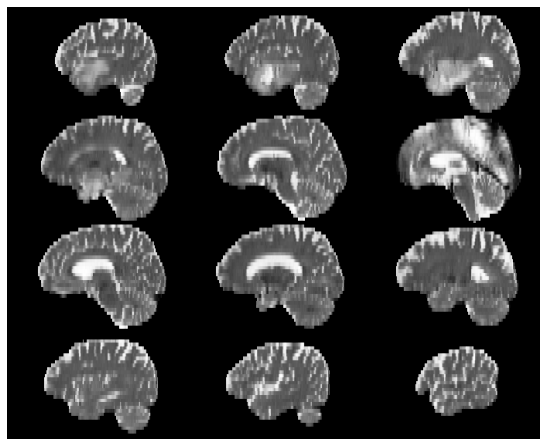

Shared


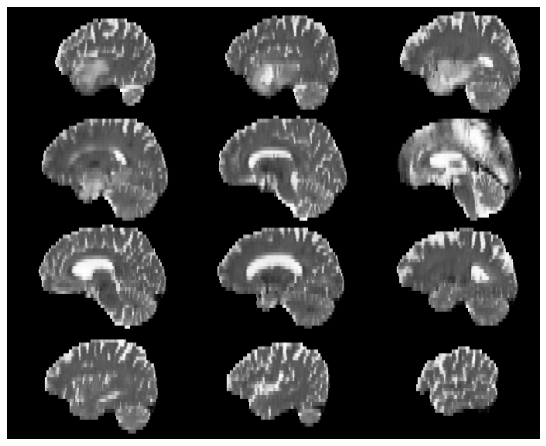

/home/kate/miniconda3/lib/python3.9/site-packages/surface_distance/metrics.py:49: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/home/kate/miniconda3/lib/python3.9/site-packages/surface_distance/metrics.py:421: RuntimeWarning:

invalid value encountered in double_scalars

/home/kate/projects/brain-mri-processing-pipeline/main_pipeline/utils/metrics.py:25: RuntimeWarning:

invalid value encountered in long_scalars



0    NaN
Name: Dice_1, dtype: object
0    NaN
Name: Surface_dice_1, dtype: object
Individual


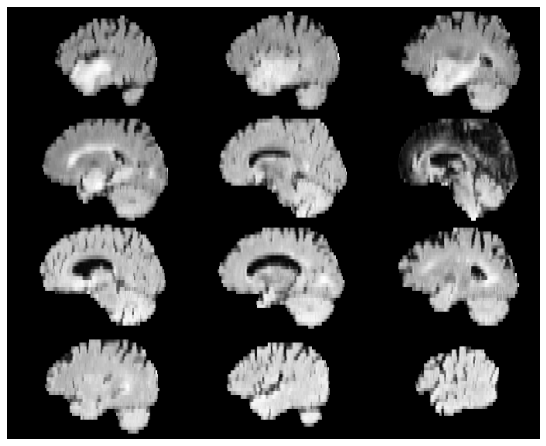

Shared


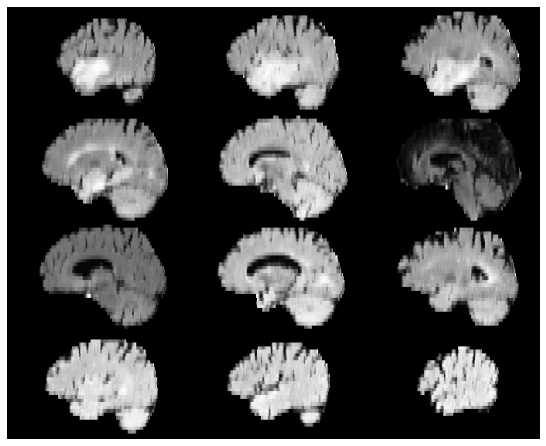

/home/kate/miniconda3/lib/python3.9/site-packages/surface_distance/metrics.py:49: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/home/kate/miniconda3/lib/python3.9/site-packages/surface_distance/metrics.py:421: RuntimeWarning:

invalid value encountered in double_scalars

/home/kate/projects/brain-mri-processing-pipeline/main_pipeline/utils/metrics.py:25: RuntimeWarning:

invalid value encountered in long_scalars



0    NaN
Name: Dice_1, dtype: object
0    NaN
Name: Surface_dice_1, dtype: object
Individual


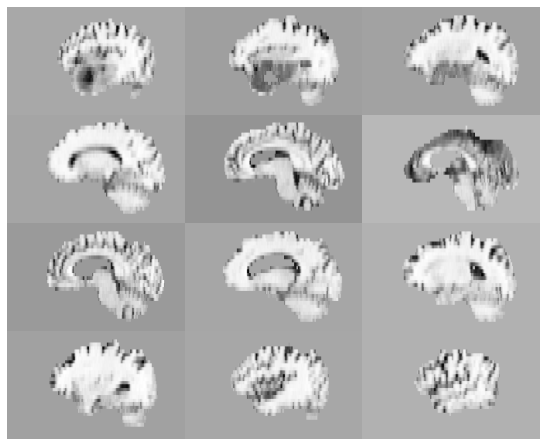

Shared


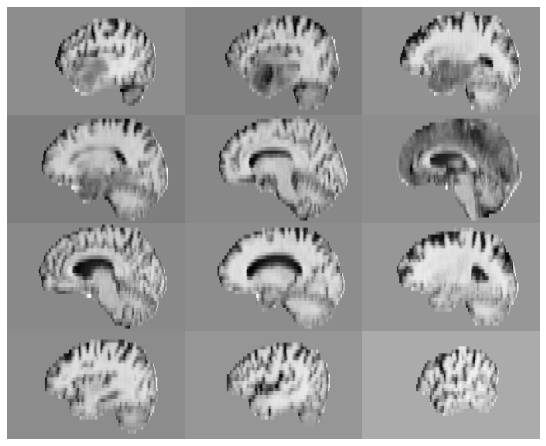

/home/kate/miniconda3/lib/python3.9/site-packages/surface_distance/metrics.py:49: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/home/kate/miniconda3/lib/python3.9/site-packages/surface_distance/metrics.py:421: RuntimeWarning:

invalid value encountered in double_scalars

/home/kate/projects/brain-mri-processing-pipeline/main_pipeline/utils/metrics.py:25: RuntimeWarning:

invalid value encountered in long_scalars



0    NaN
Name: Dice_1, dtype: object
0    NaN
Name: Surface_dice_1, dtype: object
Individual


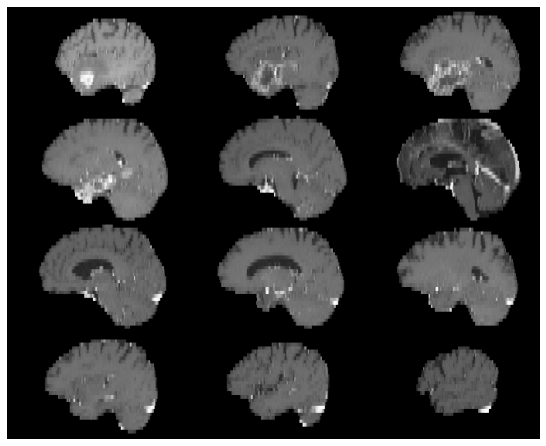

Shared


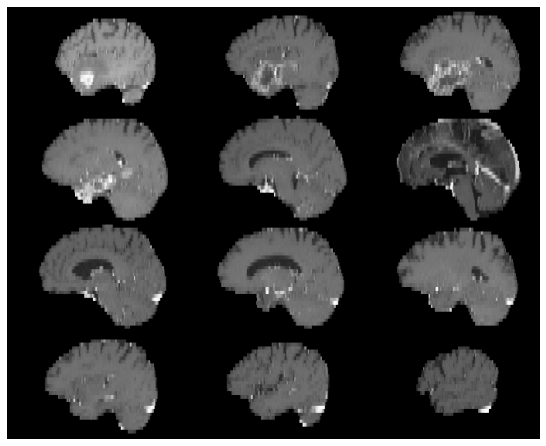

/home/kate/miniconda3/lib/python3.9/site-packages/surface_distance/metrics.py:49: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



0    NaN
Name: Dice_1, dtype: object
0    NaN
Name: Surface_dice_1, dtype: object


/home/kate/miniconda3/lib/python3.9/site-packages/surface_distance/metrics.py:421: RuntimeWarning:

invalid value encountered in double_scalars

/home/kate/projects/brain-mri-processing-pipeline/main_pipeline/utils/metrics.py:25: RuntimeWarning:

invalid value encountered in long_scalars



In [416]:
shared = '/anvar/public_datasets/preproc_study/gbm/1_reg_ss_shared'
individual = '/anvar/public_datasets/preproc_study/gbm/1_reg_ss_indiv'

image = 'TCGA-19-5951'

for mod in ['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz',  'CT1.nii.gz']:
            
        img_new = ants.image_read(shared + '/' + image +'/' + mod)
        img_old = ants.image_read(individual + '/' + image +'/' + mod)
        print('Individual')
        ants.plot(img_old)
        print('Shared')
        ants.plot(img_new)
        spacing = img_new.spacing
        df = calculate_metrics_brats(img_new.numpy(), img_old.numpy(), image, spacing)
        print(df['Dice_1'])
        print(df['Surface_dice_1'])

In [417]:
df

Ids Dice_all Dice_0 Dice_1 Dice_2 Dice_3 Hausdorff95_all  \
0  TCGA-19-5951      1.0    1.0    NaN    NaN    NaN             0.0   

  Hausdorff95_0 Hausdorff95_1 Hausdorff95_2  ... Surface_dice_0  \
0           0.0           inf           inf  ...            1.0   

  Surface_dice_1 Surface_dice_2 Surface_dice_4 Precision_all Precision_0  \
0            NaN            NaN            NaN           1.0         1.0   

  Precision_1 Precision_2 Precision_4 Dice_4  
0         NaN         NaN         NaN    NaN  

[1 rows x 32 columns]

Individual


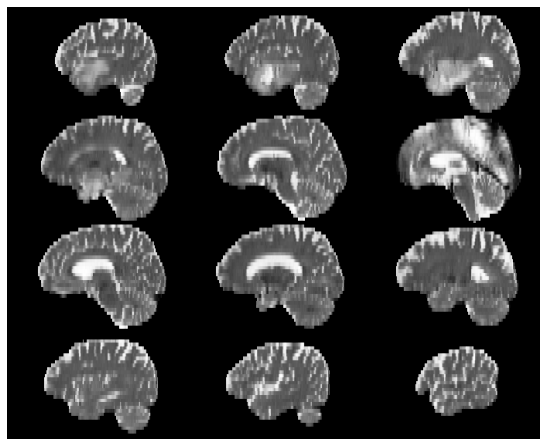

Shared


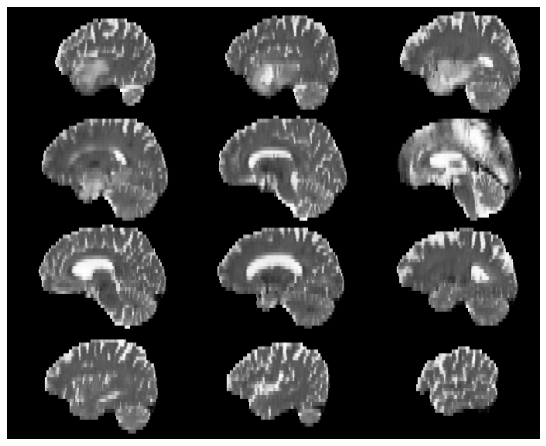

/home/kate/miniconda3/lib/python3.9/site-packages/surface_distance/metrics.py:49: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/home/kate/miniconda3/lib/python3.9/site-packages/surface_distance/metrics.py:421: RuntimeWarning:

invalid value encountered in double_scalars

/home/kate/projects/brain-mri-processing-pipeline/main_pipeline/utils/metrics.py:25: RuntimeWarning:

invalid value encountered in long_scalars



0    NaN
Name: Dice_1, dtype: object
0    NaN
Name: Surface_dice_1, dtype: object
Individual


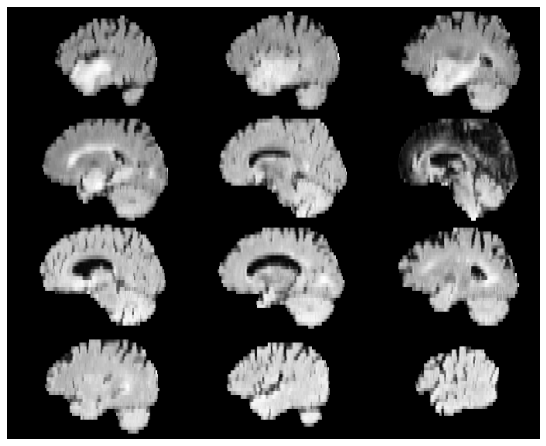

Shared


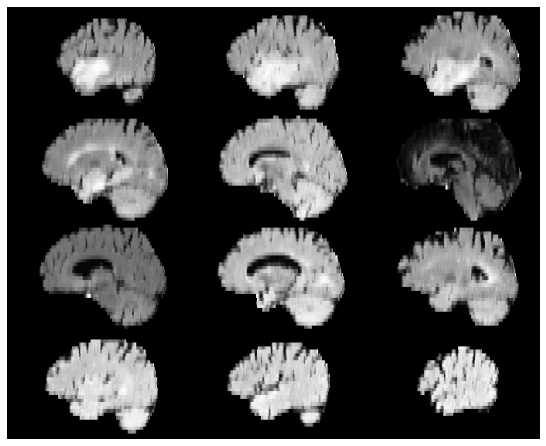

/home/kate/miniconda3/lib/python3.9/site-packages/surface_distance/metrics.py:49: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/home/kate/miniconda3/lib/python3.9/site-packages/surface_distance/metrics.py:421: RuntimeWarning:

invalid value encountered in double_scalars

/home/kate/projects/brain-mri-processing-pipeline/main_pipeline/utils/metrics.py:25: RuntimeWarning:

invalid value encountered in long_scalars



0    NaN
Name: Dice_1, dtype: object
0    NaN
Name: Surface_dice_1, dtype: object
Individual


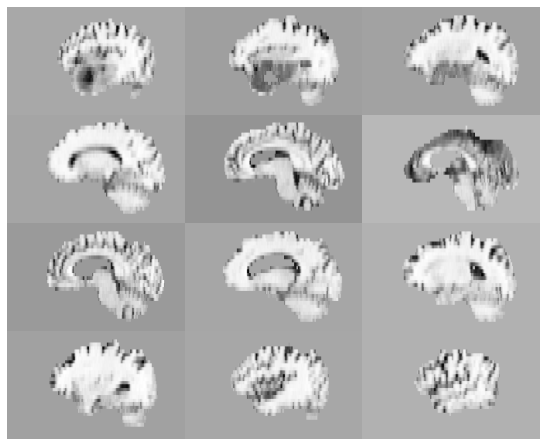

Shared


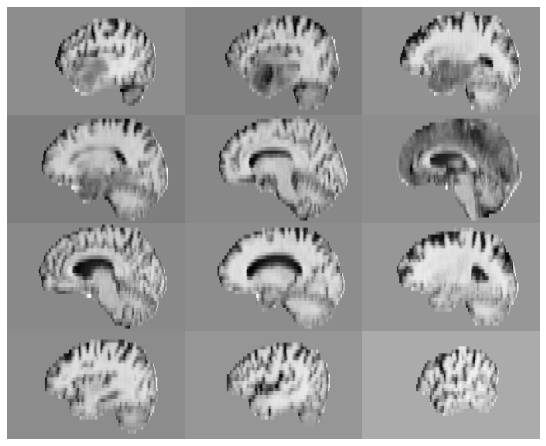

/home/kate/miniconda3/lib/python3.9/site-packages/surface_distance/metrics.py:49: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/home/kate/miniconda3/lib/python3.9/site-packages/surface_distance/metrics.py:421: RuntimeWarning:

invalid value encountered in double_scalars

/home/kate/projects/brain-mri-processing-pipeline/main_pipeline/utils/metrics.py:25: RuntimeWarning:

invalid value encountered in long_scalars



0    NaN
Name: Dice_1, dtype: object
0    NaN
Name: Surface_dice_1, dtype: object
Individual


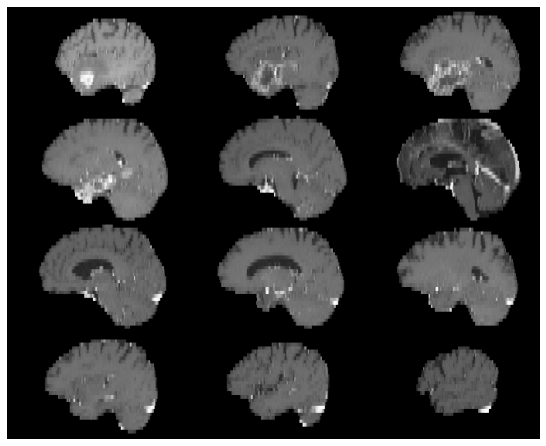

Shared


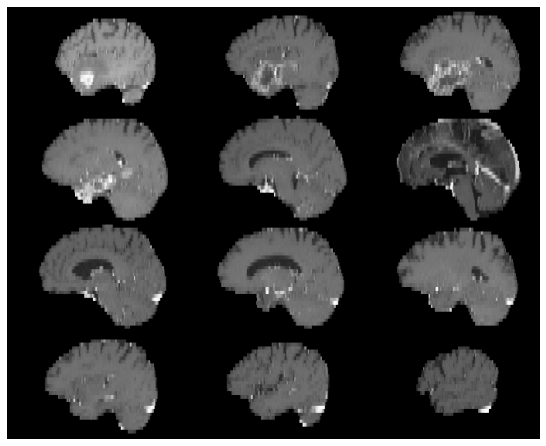

/home/kate/miniconda3/lib/python3.9/site-packages/surface_distance/metrics.py:49: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



0    NaN
Name: Dice_1, dtype: object
0    NaN
Name: Surface_dice_1, dtype: object


/home/kate/miniconda3/lib/python3.9/site-packages/surface_distance/metrics.py:421: RuntimeWarning:

invalid value encountered in double_scalars

/home/kate/projects/brain-mri-processing-pipeline/main_pipeline/utils/metrics.py:25: RuntimeWarning:

invalid value encountered in long_scalars



In [1121]:
image = 'TCGA-19-5951'

for mod in ['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz',  'CT1.nii.gz']:
            
        img_new = ants.image_read(shared + '/' + image +'/' + mod)
        img_old = ants.image_read(individual + '/' + image +'/' + mod)
        print('Individual')
        ants.plot(img_old)
        print('Shared')
        ants.plot(img_new)
        spacing = img_new.spacing
        df = calculate_metrics_brats(img_new.numpy(), img_old.numpy(), image, spacing)
        print(df['Dice_1'])
        print(df['Surface_dice_1'])

In [229]:
img_new.numpy().sum()

365447360.0

In [232]:
i_is_bigger = 0
ct1_is_bigger = 0
for image in os.listdir(shared):
    print(image)
    for mod in ['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz',  'CT1.nii.gz']:
            
            img_new = ants.image_read(shared + '/' + image +'/' + mod)
            img_old = ants.image_read(individual + '/' + image +'/' + mod)
            if img_new.numpy().sum() > img_old.numpy().sum():
                i_is_bigger +=1
            if img_new.numpy().sum() < img_old.numpy().sum():
                ct1_is_bigger +=1

TCGA-02-0086
TCGA-02-0102
TCGA-02-0059
TCGA-02-0069
TCGA-19-2624
TCGA-06-0182
TCGA-08-0360
TCGA-02-0006
TCGA-19-2631
TCGA-12-1094
TCGA-06-2570
TCGA-06-0119
TCGA-06-0145
TCGA-08-0509
TCGA-06-5408
TCGA-02-0116
TCGA-06-0188
TCGA-76-6661
TCGA-02-0047
TCGA-12-3650
TCGA-02-0064
TCGA-14-1825
TCGA-06-0162
TCGA-02-0033
TCGA-08-0359
TCGA-02-0054
TCGA-06-0184
TCGA-12-1601
TCGA-06-5413
TCGA-76-6191
TCGA-02-0075
TCGA-06-0177
TCGA-06-0154
TCGA-06-0179
TCGA-19-5951
TCGA-12-1598
TCGA-12-0616
TCGA-02-0070
TCGA-06-1084
TCGA-12-0829
TCGA-76-4932
TCGA-02-0068
TCGA-76-6282
TCGA-08-0385
TCGA-12-1098
TCGA-08-0512
TCGA-08-0389
TCGA-14-1794
TCGA-19-1789
TCGA-02-0009
TCGA-06-0122
TCGA-08-0355
TCGA-06-6389
TCGA-06-0190
TCGA-06-0192
TCGA-02-0027
TCGA-06-0137
TCGA-12-0776
TCGA-76-6657
TCGA-06-0176
TCGA-08-0356
TCGA-76-6662
TCGA-08-0522
TCGA-06-1802
TCGA-19-5960
TCGA-08-0390
TCGA-14-1456
TCGA-06-0158
TCGA-06-0139
TCGA-06-0238
TCGA-76-4935
TCGA-14-3477
TCGA-02-0106
TCGA-06-0644
TCGA-19-0963
TCGA-06-0187
TCGA-76-6664

ValueError: File /anvar/public_datasets/preproc_study/gbm/1_reg_ss_shared/logging.txt/T2.nii.gz does not exist!

In [233]:
i_is_bigger, ct1_is_bigger

(57, 240)

In [236]:
102*4 - 240 - 57

111

1. проверить в скольких случаях разметка выходит за маску

сделать lgg датасет

In [270]:
np.round(5,3)

5

In [272]:
result = pd.DataFrame(['patient', 'mode', 'dice', 'persent'])

for image in os.listdir(shared):
    print(image)
    img_new = ants.image_read(shared + '/' + image +'/' + 'CT1_mask.nii.gz').numpy()   
    mask = ants.image_read(individual + '/' + image +'/' + 'CT1_SEG.nii.gz').numpy()
    mask[mask > 0 ] = 1
    substr = mask - img_new
    substr [substr < 0 ] = 0
    if substr.sum() > 0:
        print('Patient ', image, 'CT1 ', np.round(substr.sum()/mask.sum()*100,1) ,'%')
        result = result.append({'patient': image,
               'mode': 'CT1',
               'voxels': substr.sum(),
               'persent': substr.sum()/mask.sum()}, ignore_index = True)
        
        
    for mod in ['T2_mask.nii.gz', 'FLAIR_mask.nii.gz', 'T1_mask.nii.gz']:
                        
            img_old = ants.image_read(individual + '/' + image +'/' + mod).numpy()
            mask[mask > 0 ] = 1
            substr = mask - img_old
            substr [substr < 0 ] = 0
            if substr.sum() > 0:
                print('Patient ', image, mod,np.round(substr.sum()/mask.sum()*100,1)  ,'%')
                result = result.append({'patient': image,'mode': mod,'voxels': substr.sum(),
                                        'persent': substr.sum()/mask.sum()}, ignore_index = True)
            

TCGA-02-0086
Patient  TCGA-02-0086 CT1  0.1 %
Patient  TCGA-02-0086 T1_mask.nii.gz 0.0 %
TCGA-02-0102
TCGA-02-0059
Patient  TCGA-02-0059 CT1  0.3 %
TCGA-02-0069
Patient  TCGA-02-0069 CT1  0.7 %
Patient  TCGA-02-0069 T2_mask.nii.gz 0.0 %
Patient  TCGA-02-0069 FLAIR_mask.nii.gz 0.0 %
Patient  TCGA-02-0069 T1_mask.nii.gz 0.0 %
TCGA-19-2624
Patient  TCGA-19-2624 CT1  4.3 %
Patient  TCGA-19-2624 T2_mask.nii.gz 4.4 %
Patient  TCGA-19-2624 FLAIR_mask.nii.gz 4.0 %
Patient  TCGA-19-2624 T1_mask.nii.gz 4.7 %
TCGA-06-0182
Patient  TCGA-06-0182 CT1  0.1 %
Patient  TCGA-06-0182 T2_mask.nii.gz 0.0 %
Patient  TCGA-06-0182 FLAIR_mask.nii.gz 0.0 %
TCGA-08-0360
TCGA-02-0006
TCGA-19-2631
Patient  TCGA-19-2631 T2_mask.nii.gz 0.0 %
Patient  TCGA-19-2631 T1_mask.nii.gz 0.0 %
TCGA-12-1094
TCGA-06-2570
Patient  TCGA-06-2570 CT1  0.0 %
Patient  TCGA-06-2570 T1_mask.nii.gz 0.0 %
TCGA-06-0119
Patient  TCGA-06-0119 CT1  13.7 %
Patient  TCGA-06-0119 T2_mask.nii.gz 12.6 %
Patient  TCGA-06-0119 FLAIR_mask.nii.gz 12.

ValueError: File /anvar/public_datasets/preproc_study/gbm/1_reg_ss_shared/logging.txt/CT1_mask.nii.gz does not exist!

In [287]:
result['persent'].mean(), result['persent'].std(), result['persent'].max()

(0.010269908, 0.028796652, 0.15832591)

In [291]:
os.mkdir('/anvar/public_datasets/preproc_study/gbm/3d_susan/')

FileExistsError: [Errno 17] File exists: '/anvar/public_datasets/preproc_study/gbm/3d_susan/'

In [290]:
result

0               mode       patient   persent  voxels
0    patient                NaN           NaN       NaN     NaN
1       mode                NaN           NaN       NaN     NaN
2     voxels                NaN           NaN       NaN     NaN
3    persent                NaN           NaN       NaN     NaN
4        NaN                CT1  TCGA-02-0086  0.000755    36.0
..       ...                ...           ...       ...     ...
146      NaN     T1_mask.nii.gz  TCGA-06-0646  0.000075     4.0
147      NaN                CT1  TCGA-02-0046  0.008805   360.0
148      NaN     T2_mask.nii.gz  TCGA-02-0046  0.003253   133.0
149      NaN  FLAIR_mask.nii.gz  TCGA-02-0046  0.004207   172.0
150      NaN     T1_mask.nii.gz  TCGA-02-0046  0.010615   434.0

[151 rows x 5 columns]

In [247]:
np.unique(img_old)

array([   0.,   12.,   20., ..., 2928., 2953., 2962.], dtype=float32)

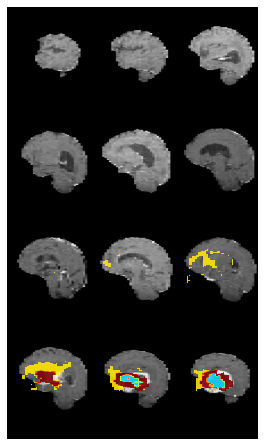

In [273]:
img_new = ants.image_read(shared + '/' + 'TCGA-06-0119' +'/' + 'CT1.nii.gz')
label = ants.image_read(shared + '/' + 'TCGA-06-0119' +'/' + 'CT1_SEG.nii.gz')
ants.plot(img_new,label)

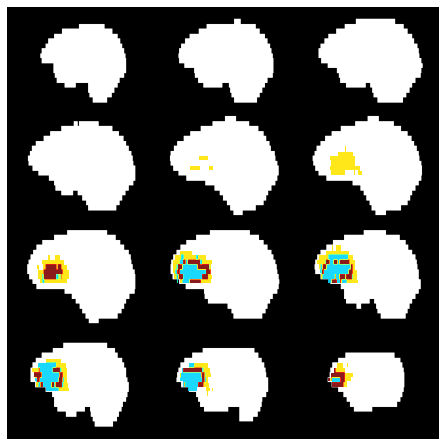

In [261]:
img_new = ants.image_read(shared + '/' + 'TCGA-76-6663' +'/' + 'CT1_mask.nii.gz')
label = ants.image_read(shared + '/' + 'TCGA-76-6663' +'/' + 'CT1_SEG.nii.gz')
ants.plot(img_new,label)

In [262]:
label[label > 0 ] = 1
substr = label - img_new
substr [substr < 0 ] = 0

In [266]:
substr.sum() /label.sum()

0.010256773

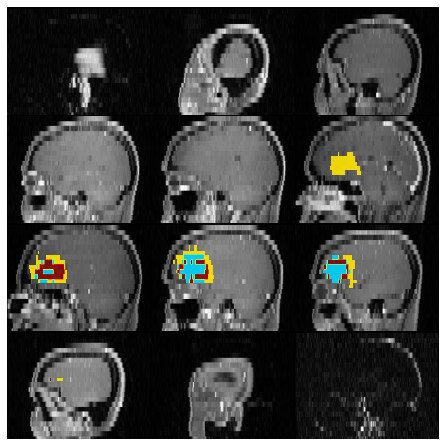

In [260]:
img_new = ants.image_read('/anvar/public_datasets/preproc_study/gbm/orig/' + '/' + 'TCGA-76-6663' +'/' + 'CT1.nii.gz')
label = ants.image_read(shared + '/' + 'TCGA-76-6663' +'/' + 'CT1_SEG.nii.gz')
ants.plot(img_new,label)

## Test GBM 

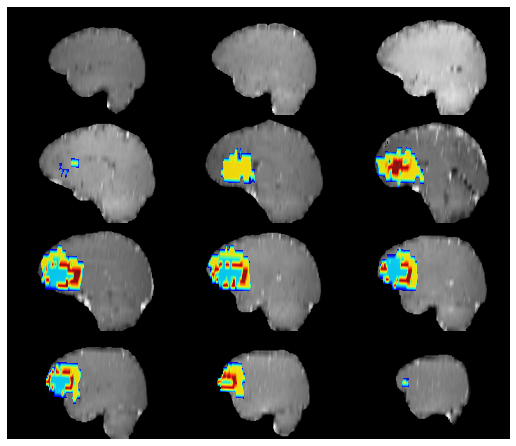

In [299]:
img_new = ants.image_read('/anvar/public_datasets/preproc_study/gbm/5_ss_shared/' + '/' + 'TCGA-76-6663' +'/' + 'CT1.nii.gz')
label = ants.image_read('/anvar/public_datasets/preproc_study/gbm/5_ss_shared/' + '/' + 'TCGA-76-6663' +'/' + 'CT1_SEG.nii.gz')
ants.plot(img_new,label)

In [305]:
np.unique(label.numpy().astype('uint8'))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=uint8)

In [306]:
np.unique(label_.numpy().astype('uint8'))

array([0, 1, 2, 4], dtype=uint8)

In [295]:
img_new

ANTsImage (RPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (240, 240, 155)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-119.0, 129.0, -68.0)
	 Direction  : [ 1.  0.  0.  0. -1.  0.  0.  0.  1.]

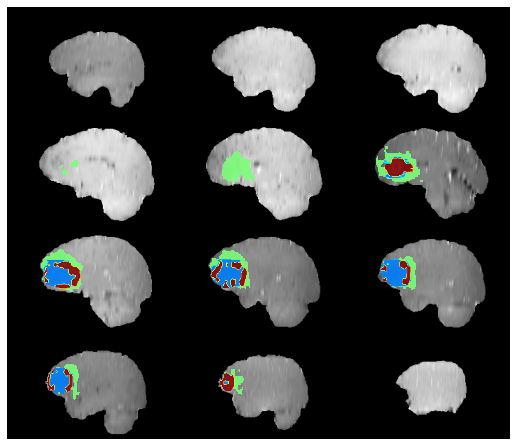

In [298]:
img_new_ = ants.image_read('/anvar/public_datasets/tcia/Pre-operative_TCGA_GBM_NIfTI_and_Segmentations/' + '/' + 'TCGA-76-6663' +'/' + 'CT1.nii.gz')
label_ = ants.image_read('/anvar/public_datasets/tcia/Pre-operative_TCGA_GBM_NIfTI_and_Segmentations/' + '/' + 'TCGA-76-6663' +'/' + 'CT1_SEG.nii.gz')
ants.plot(img_new,label)

In [297]:
img_new

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (240, 240, 155)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, -239.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

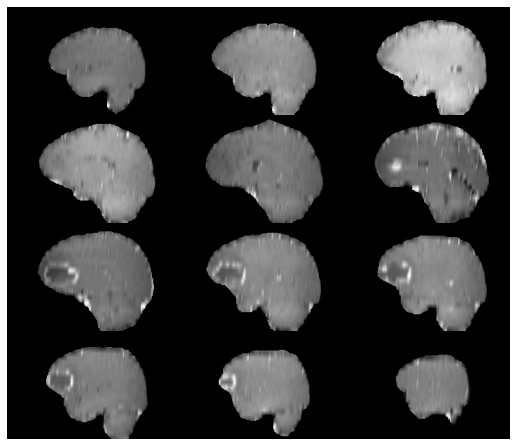

In [301]:
ants.plot(img_new,label_)

## Resample img

In [309]:
ct1_test = ants.image_read('/anvar/public_datasets/preproc_study/gbm/1_reg/' + 'TCGA-12-1094/CT1.nii.gz')
ct1_test

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (256, 256, 22)
	 Spacing    : (0.9375, 0.9375, 6.5)
	 Origin     : (-120.0, -104.8, -59.3989)
	 Direction  : [ 1.e+00  0.e+00  0.e+00  0.e+00  1.e+00 -8.e-04  0.e+00  8.e-04  1.e+00]

In [311]:
ct1_resample = ants.resample_image(ct1_test,(1, 1, 1), False, 0)

In [312]:
ct1_resample 

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (240, 240, 143)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-120.0, -104.8, -59.3989)
	 Direction  : [ 1.e+00  0.e+00  0.e+00  0.e+00  1.e+00 -8.e-04  0.e+00  8.e-04  1.e+00]

In [315]:
256*0.9375

240.0

## Experiment with registration

In [342]:
ss_reg_dir = '/anvar/public_datasets/preproc_study/gbm/ss_indiv_reg'
reg_ss_dir = '/anvar/public_datasets/preproc_study/gbm/1_reg_ss_indiv'

In [348]:
# мы хотим проверитьь какое отличие, тогда нужно бинаризовать картинку регистрации и сравнить с маской на 1_reg_ss_indiv

result = pd.DataFrame(['patient', 'mode', 'voxels', 'persent'])

for image in os.listdir(ss_reg_dir):
    print(image)
    # загружаем картинку скастрип, потом регистер. она считается больше, чем вторая
    img_new = ants.image_read(ss_reg_dir + '/' + image +'/' + 'CT1.nii.gz')
    spacing = img_new.spacing
    img_new = img_new.numpy()   
    mask = ants.image_read(reg_ss_dir + '/' + image +'/' + 'CT1_mask.nii.gz').numpy()
    # бинаризуем картинку
    img_new[img_new > 0 ] = 1
    substr = img_new - mask
    substr [substr < 0 ] = 0
    
    df = calculate_metrics_brats(img_new, mask, image, spacing)    
    
    if substr.sum() > 0:
        print('Patient ', image, 'CT1 ', 'Dice', df['Dice_1'][0], np.round(substr.sum()/mask.sum()*100,1) ,'%')
        result = result.append({'patient': image,
               'mode': 'CT1',
               'voxels': df['Dice_1'][0],
               'persent': substr.sum()/mask.sum()}, ignore_index = True)
        
        
    for mod in ['T2', 'FLAIR', 'T1']:
                        
            img_new = ants.image_read(ss_reg_dir + '/' + image +'/' + mod +'.nii.gz')
            spacing = img_new.spacing
            img_new = img_new.numpy()  
            mask = ants.image_read(reg_ss_dir + '/' + image +'/' + mod +'_mask.nii.gz').numpy()
            # бинаризуем картинку
            img_new[img_new > 0 ] = 1
            substr = img_new - mask
            substr [substr < 0 ] = 0
            
            df = calculate_metrics_brats(img_new, mask, image, spacing) 
            
            if substr.sum() > 0:
                print('Patient ', image, mod, 'Dice', df['Dice_1'][0], np.round(substr.sum()/mask.sum()*100,1)  ,'%')
                result = result.append({'patient': image,
                                        'mode': mod,
                                        'dice': df['Dice_1'][0],
                                        'persent': substr.sum()/mask.sum()}, ignore_index = True)

TCGA-02-0086


/home/kate/miniconda3/lib/python3.9/site-packages/surface_distance/metrics.py:49: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/home/kate/projects/brain-mri-processing-pipeline/main_pipeline/utils/metrics.py:25: RuntimeWarning:

invalid value encountered in long_scalars



Patient  TCGA-02-0086 T2 Dice 0.9558343550528536 8.6 %
Patient  TCGA-02-0086 FLAIR Dice 0.9545909582348937 9.4 %
Patient  TCGA-02-0086 T1 Dice 0.9564219448922292 9.1 %
TCGA-02-0102
Patient  TCGA-02-0102 T2 Dice 0.958424759375631 8.4 %
Patient  TCGA-02-0102 FLAIR Dice 0.9594003668854354 8.2 %
Patient  TCGA-02-0102 T1 Dice 0.955761357764617 9.0 %
TCGA-02-0059
Patient  TCGA-02-0059 T2 Dice 0.9583753285578426 8.4 %
Patient  TCGA-02-0059 FLAIR Dice 0.9582480578545086 8.5 %
Patient  TCGA-02-0059 T1 Dice 0.9804444478787452 3.2 %
TCGA-02-0069
Patient  TCGA-02-0069 T2 Dice 0.9571817966224146 8.8 %
Patient  TCGA-02-0069 FLAIR Dice 0.9517876296053885 9.4 %
Patient  TCGA-02-0069 T1 Dice 0.957529582933451 8.5 %
TCGA-19-2624
Patient  TCGA-19-2624 T2 Dice 0.9553143996293748 9.2 %
Patient  TCGA-19-2624 FLAIR Dice 0.9550722342935958 9.3 %
Patient  TCGA-19-2624 T1 Dice 0.9558353298331947 9.0 %
TCGA-06-0182
Patient  TCGA-06-0182 T2 Dice 0.962039823641107 7.6 %
Patient  TCGA-06-0182 FLAIR Dice 0.972494907

KeyboardInterrupt: 

In [352]:
result['persent'].mean()

0.0772872

In [349]:
df.mean()

/tmp/ipykernel_1221982/3698961737.py:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



Dice_all            0.958294
Dice_0              0.984639
Dice_1              0.958294
Dice_2              0.000000
Dice_3                   NaN
Hausdorff95_all     6.500000
Hausdorff95_0       2.541165
Hausdorff95_1       6.500000
Hausdorff95_2            inf
Hausdorff95_4            inf
Sensitivity_all     0.920646
Sensitivity_0       0.999696
Sensitivity_1       0.920646
Sensitivity_2       0.000000
Sensitivity_4       0.000000
Specificity_all     0.999696
Specificity_0       0.920646
Specificity_1       0.999696
Specificity_2       1.000000
Specificity_4       1.000000
Surface_dice_all    0.746811
Surface_dice_0      0.915789
Surface_dice_1      0.746811
Surface_dice_2      0.000000
Surface_dice_4      0.000000
Precision_all       0.999153
Precision_0         0.970028
Precision_1         0.999153
Precision_2              NaN
Precision_4              NaN
Dice_4              0.000000
dtype: float64

## Labels to overlay

In [353]:
predict_atlas =  '/anvar/public_datasets/preproc_study/gbm/3a_atlas/'
predict_ss =  '/anvar/public_datasets/preproc_study/gbm/5_ss_shared/'

In [355]:
os.listdir(predict_atlas + 'TCGA-02-0086')

['T2.nii.gz', 'FLAIR.nii.gz', 'T1.nii.gz', 'CT1_SEG.nii.gz', 'CT1.nii.gz']

In [395]:
seg_1 = ants.image_read(predict_atlas + 'TCGA-02-0086/' + 'CT1_SEG.nii.gz')
seg_2 = ants.image_read(predict_ss + 'TCGA-02-0086/' + 'CT1_SEG.nii.gz')
image_ss = ants.image_read(predict_ss + 'TCGA-02-0086/' + 'CT1.nii.gz')
image_atlas = ants.image_read(predict_atlas + 'TCGA-02-0086/' + 'CT1.nii.gz')

In [360]:
seg_1

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (240, 240, 155)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (120.0, 129.0, -68.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [373]:
seg_1.direction

array([[-1.,  0.,  0.],
       [ 0., -1.,  0.],
       [ 0.,  0.,  1.]])

In [374]:
seg_2.set_direction(seg_1.direction)

In [375]:
seg_2

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (240, 240, 155)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (-119.0, 129.0, -68.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [385]:
np.allclose(seg_1.numpy(), seg_2.numpy())

False

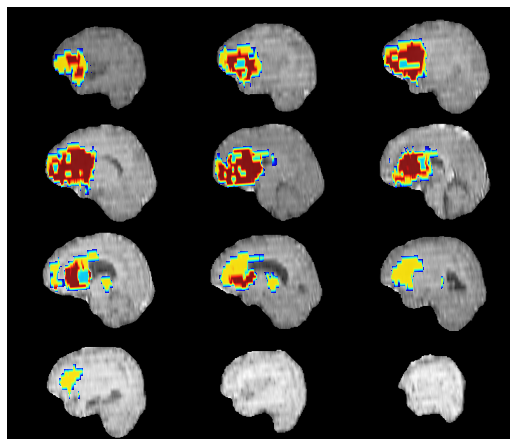

In [384]:
ants.plot(image_ss, seg_2)

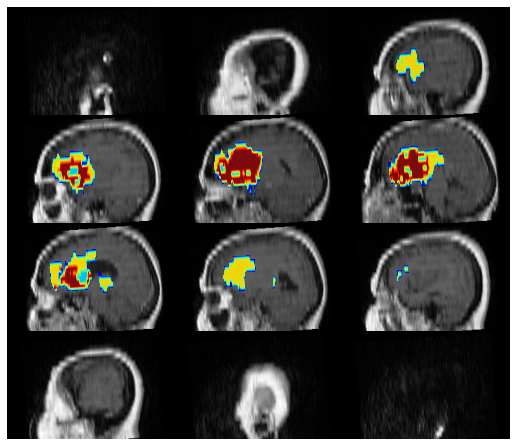

In [383]:
ants.plot(image_atlas, seg_2)

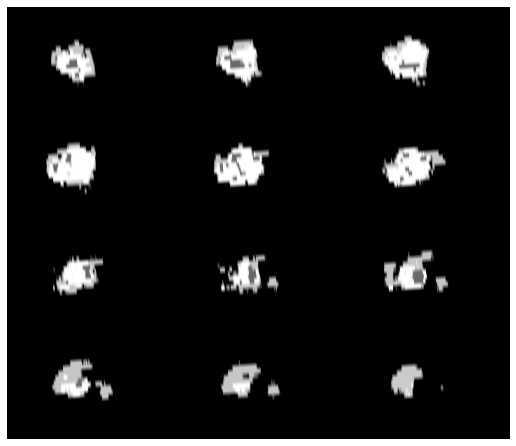

In [378]:
ants.plot(seg_1, seg_2)

In [386]:
def plot_qc(image, mask, patient_id):
    fig, axs = plt.subplots(3,3,figsize=(12,12))
    idx = np.argsort(mask.sum(axis=(0,1)))[-3:]
    for i in range(3):
        axs[i, 0].imshow(image[..., idx[i]], cmap='gray')
        axs[i, 1].imshow(mask[..., idx[i]], cmap='gray')
        axs[i, 2].imshow(image[..., idx[i]]+200*mask[..., idx[i]], cmap='gray')
    axs[0,0].set_title(patient_id)
    plt.tight_layout()
#     plt.savefig(f'/home/kate/projects/qc_preprocessing/{path}_gbm/{patient_id}.png', dpi=300)
    plt.plot()
#     plt.close(fig)


# plot_qc(im, mask, patient_id=str(patient))

### Experiment with variance

In [419]:
# 1. Calctulate hist for 100 bars and min/max scale it
# 2. plot mean and variance of these hist for tumor, and all head


In [439]:
os.listdir('/anvar/public_datasets/preproc_study/gbm/6_hist/gbm_3a_atlas_train/images/')

['TCGA-08-0389.nii.gz',
 'TCGA-02-0087.nii.gz',
 'TCGA-02-0102.nii.gz',
 'TCGA-08-0392.nii.gz',
 'TCGA-08-0520.nii.gz',
 'TCGA-06-0130.nii.gz',
 'TCGA-06-5408.nii.gz',
 'TCGA-76-6285.nii.gz',
 'TCGA-06-0137.nii.gz',
 'TCGA-12-1094.nii.gz',
 'TCGA-02-0069.nii.gz',
 'TCGA-08-0355.nii.gz',
 'TCGA-02-0047.nii.gz',
 'TCGA-08-0390.nii.gz',
 'TCGA-19-2631.nii.gz',
 'TCGA-06-5417.nii.gz',
 'TCGA-02-0033.nii.gz',
 'TCGA-02-0027.nii.gz',
 'TCGA-06-0122.nii.gz',
 'TCGA-12-1598.nii.gz',
 'TCGA-14-1825.nii.gz',
 'TCGA-02-0085.nii.gz',
 'TCGA-02-0075.nii.gz',
 'TCGA-06-1802.nii.gz',
 'TCGA-02-0070.nii.gz',
 'TCGA-02-0037.nii.gz',
 'TCGA-08-0512.nii.gz',
 'TCGA-19-2624.nii.gz',
 'TCGA-06-0646.nii.gz',
 'TCGA-19-1789.nii.gz',
 'TCGA-12-0616.nii.gz',
 'TCGA-06-0188.nii.gz',
 'TCGA-02-0106.nii.gz',
 'TCGA-02-0046.nii.gz',
 'TCGA-08-0509.nii.gz',
 'TCGA-06-0138.nii.gz',
 'TCGA-12-3650.nii.gz',
 'TCGA-76-6661.nii.gz',
 'TCGA-12-1098.nii.gz',
 'TCGA-12-1601.nii.gz',
 'TCGA-06-0164.nii.gz',
 'TCGA-19-5954.n

In [442]:
test_img = ants.image_read('/anvar/public_datasets/preproc_study/gbm/6_hist/gbm_3a_atlas_train/images/TCGA-08-0389.nii.gz')
test_mask = ants.image_read('/anvar/public_datasets/preproc_study/gbm/6_hist/gbm_3a_atlas_train/labels/TCGA-08-0389_seg.nii.gz')

In [447]:
test_mask.shape

(240, 240, 155)

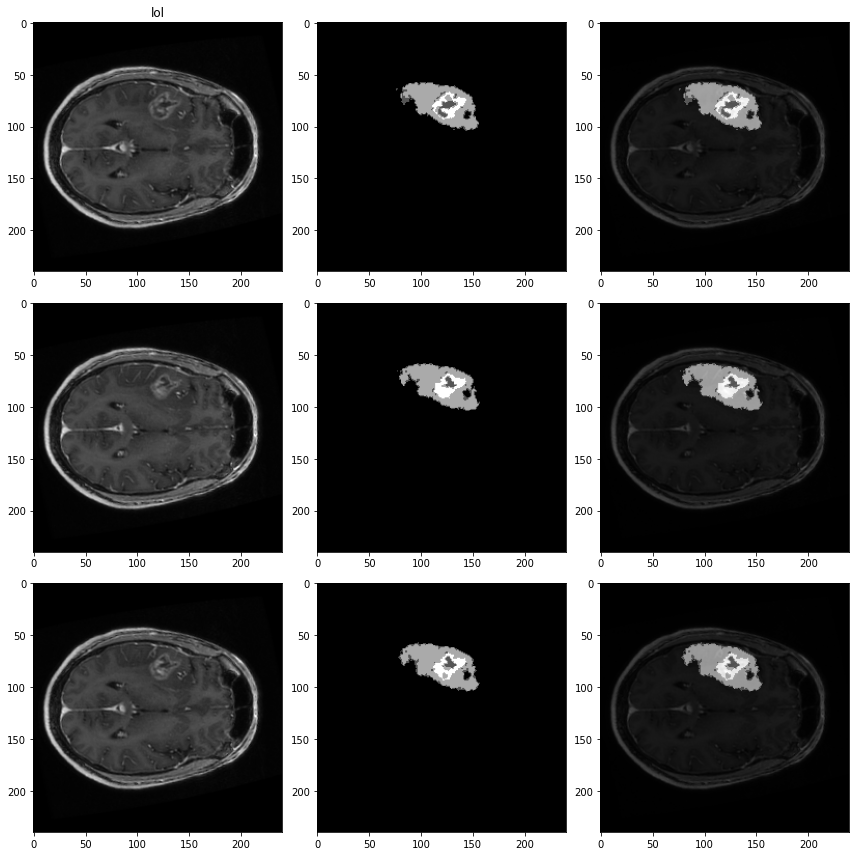

In [452]:
plot_qc(test_img[:,:,:,2],test_mask,'lol')

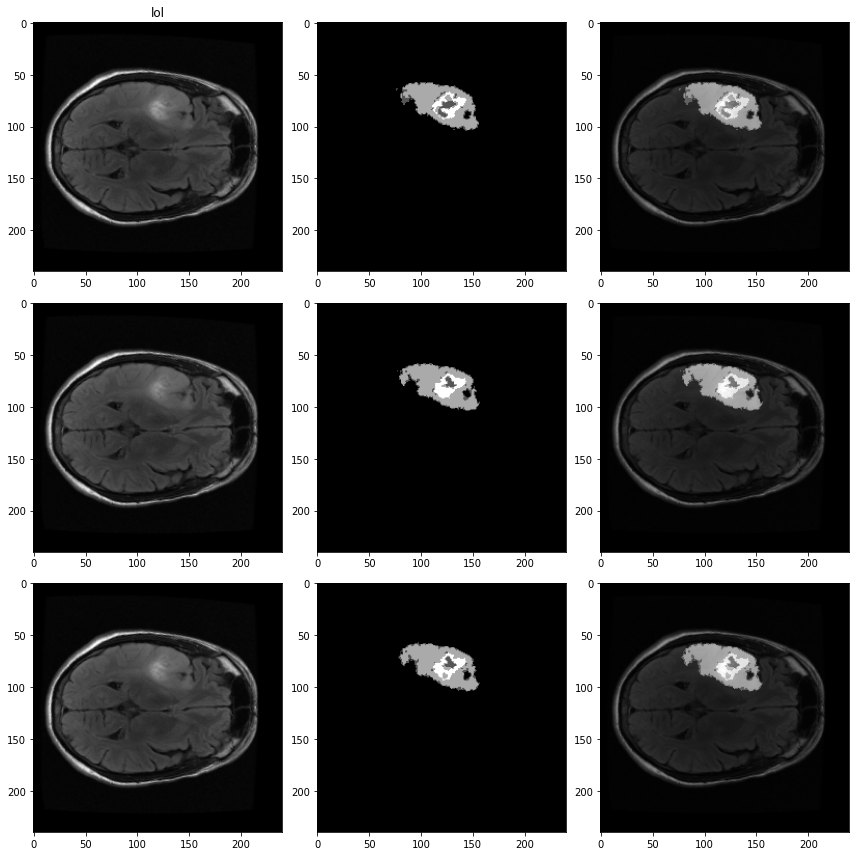

In [449]:
plot_qc(test_img[:,:,:,0],test_mask,'lol')

In [ ]:
## starting in folds

In [837]:
import mpu.io
gbm_seed = mpu.io.read('utils/example.json')

In [838]:
def calculate_z_score(img):
    """ Calculates Z-score normalisation over ants.img and returns new image"""
    
    if type(img) is str:
        # Read images if input is pathlike
        img = ants.image_read(img)
        
    img_z = (img.numpy() - img.numpy().mean())/img.numpy().std()
    new_img = img.new_image_like(img_z)
    return new_img

def scaler_min_max(array):
    return (array - array.min())/(array.max() - array.min())

In [839]:
brain_mask.numpy().shape

(240, 240, 155)

In [867]:
save_dir = '/anvar/public_datasets/preproc_study/gbm/6_hist/6_histogram'
base_dir = '/anvar/public_datasets/preproc_study/gbm/3a_atlas/'

In [881]:
len(os.listdir(save_dir +'/6_hist_fold_0'))

73

In [1036]:
ants.image_read(glob(save_dir + '/6_hist_{}/'.format(fold) + patient +'/CT1.nii.gz')[0])

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (240, 240, 155)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (120.0, 129.0, -68.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [1037]:
ants.image_read(glob(base_dir + patient + '/CT1.nii.gz')[0])

ANTsImage (LPI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (240, 240, 155)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (120.0, 129.0, -68.0)
	 Direction  : [-1.  0.  0.  0. -1.  0.  0.  0.  1.]

In [907]:
gbm_seed[fold][0]

'TCGA-02-0011'

In [908]:
for fold in ['fold_0']:
    for patient in gbm_seed[fold][1:4]:
        hist_img_path = glob(save_dir + '/6_hist_{}/'.format(fold) + patient +'/CT1.nii.gz')[0]
        orig_img_path = glob(base_dir + patient + '/CT1.nii.gz')[0]
        tumor_mask_path = glob(base_dir + patient + '/CT1_SEG.nii.gz')[0]
        brain_mask_path = glob(save_dir + '/6_hist_brain_masks/' +'{}_mask.nii.gz'.format(patient))[0]   

In [1026]:
patient = 'TCGA-02-0011'
immg_fold_1 = ants.image_read(save_dir + '/6_hist_fold_1/' + patient +'/CT1.nii.gz')
immg_fold_2 = ants.image_read(save_dir + '/6_hist_fold_2/' + patient +'/CT1.nii.gz')
immg_fold_0 = ants.image_read(save_dir + '/6_hist_fold_0/' + patient +'/CT1.nii.gz')

In [1029]:
print(np.allclose(immg_fold_1.numpy() , immg_fold_0.numpy()))

False


False


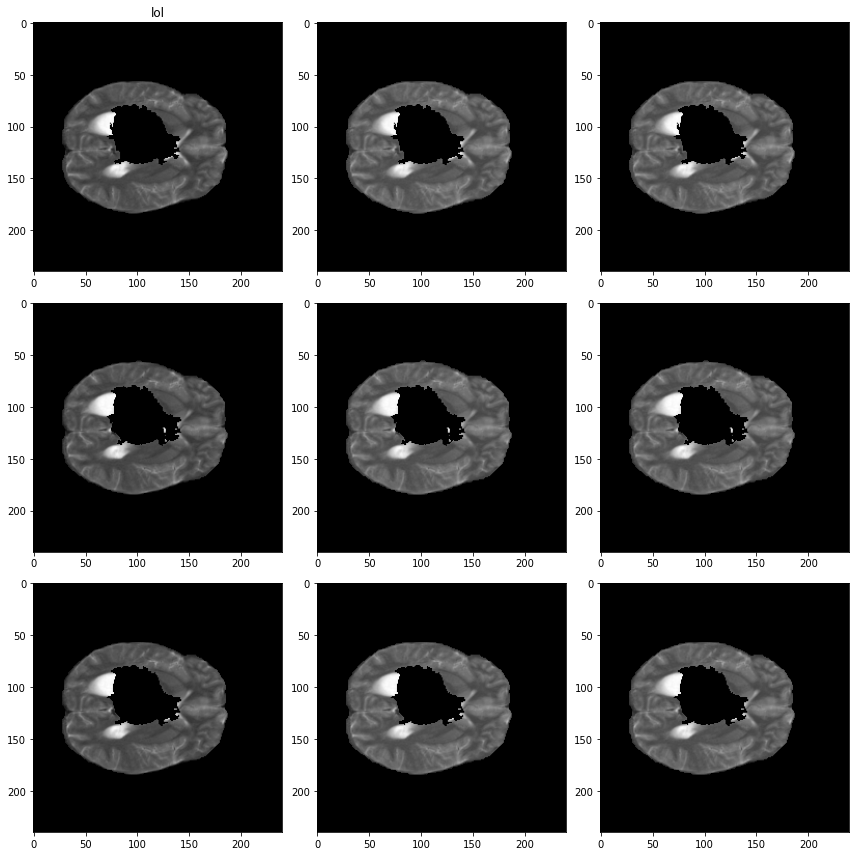

In [1035]:
patient = 'TCGA-02-0011'
fold =  'fold_1'
hist_img_path = glob(save_dir + '/6_hist_{}/'.format(fold) + patient +'/T2.nii.gz')[0]
orig_img_path = glob(base_dir + patient + '/T2.nii.gz')[0]
tumor_mask_path = glob(base_dir + patient + '/CT1_SEG.nii.gz')[0]
brain_mask_path = glob(save_dir + '/6_hist_brain_masks/' +'{}_mask.nii.gz'.format(patient))[0]   

hist_img = ants.image_read(hist_img_path)
orig_img = ants.image_read(orig_img_path)
tumor_mask = ants.image_read(tumor_mask_path)
brain_mask = ants.image_read(brain_mask_path)

tumor_mask = tumor_mask.numpy() > 0
brain_mask = brain_mask.numpy() > 0

brain_hist = hist_img.numpy()*((~tumor_mask)&brain_mask*1)               
orig_hist = orig_img.numpy()*((~tumor_mask)&brain_mask*1)
plot_qc(orig_hist , brain_hist,   'lol')
print(np.allclose(orig_hist , brain_hist))

In [975]:
patient = 'TCGA-02-0033'
hist_img_path = glob(save_dir + '/6_hist_{}/'.format(fold) + patient +'/CT1.nii.gz')[0]
orig_img_path = glob(base_dir + patient + '/CT1.nii.gz')[0]
tumor_mask_path = glob(base_dir + patient + '/CT1_SEG.nii.gz')[0]
brain_mask_path = glob(save_dir + '/6_hist_brain_masks/' +'{}_mask.nii.gz'.format(patient))[0]   

bins = np.arange(0,1, 0.01)

hist_img = ants.image_read(hist_img_path)
orig_img = ants.image_read(orig_img_path)
tumor_mask = ants.image_read(tumor_mask_path)
brain_mask = ants.image_read(brain_mask_path)

tumor_mask = tumor_mask.numpy() > 0
brain_mask = brain_mask.numpy() > 0
hist_tumor= hist_img.numpy()[tumor_mask]
orig_tumor = orig_img.numpy()[tumor_mask]

hist_brain = hist_img.numpy()[(~tumor_mask)&brain_mask]                 
orig_brain = orig_img.numpy()[(~tumor_mask)&brain_mask]  

hist_tumor_dataframe = pd.DataFrame(columns = bins)
a_series = pd.Series(np.histogram(hist_tumor, bins = 100, normed =True)[0], bins )
hist_tumor_dataframe = hist_tumor_dataframe.append(a_series, ignore_index=True)     

hist_brain_dataframe = pd.DataFrame(columns = bins)
b_series = pd.Series(np.histogram(hist_brain, bins = 100, normed =True)[0], bins )
hist_brain_dataframe = hist_brain_dataframe.append(b_series, ignore_index=True)    

orig_brain_dataframe = pd.DataFrame(columns = bins)
c_series = pd.Series(np.histogram(orig_brain, bins = 100, normed =True)[0], bins )
orig_brain_dataframe = orig_brain_dataframe.append(c_series, ignore_index=True)    

orig_tumor_dataframe = pd.DataFrame(columns = bins)
d_series = pd.Series(np.histogram(orig_tumor, bins = 100, normed =True)[0], bins )
orig_tumor_dataframe = orig_tumor_dataframe.append(d_series, ignore_index=True)    

In [1025]:
hist_tumor_dataframe = pd.DataFrame(columns = bins)
hist_brain_dataframe = pd.DataFrame(columns = bins)
orig_tumor_dataframe = pd.DataFrame(columns = bins)
orig_brain_dataframe = pd.DataFrame(columns = bins)

for fold in ['fold_0']:
    for patient in os.listdir(base_dir):
        if os.path.isdir(base_dir + patient):
#             print(patient)
            hist_img_path = glob(save_dir + '/6_hist_{}/'.format(fold) + patient +'/CT1.nii.gz')[0]
            orig_img_path = glob(base_dir + patient + '/CT1.nii.gz')[0]
            tumor_mask_path = glob(base_dir + patient + '/CT1_SEG.nii.gz')[0]
            brain_mask_path = glob(save_dir + '/6_hist_brain_masks/' +'{}_mask.nii.gz'.format(patient))[0]   

            hist_img = ants.image_read(hist_img_path)
            orig_img = ants.image_read(orig_img_path)
            tumor_mask = ants.image_read(tumor_mask_path)
            brain_mask = ants.image_read(brain_mask_path)

            tumor_mask = tumor_mask.numpy() > 0
            brain_mask = brain_mask.numpy() > 0
            hist_tumor= hist_img.numpy()[tumor_mask]
            orig_tumor = orig_img.numpy()[tumor_mask]

            hist_brain = hist_img.numpy()[(~tumor_mask)&brain_mask]                 
            orig_brain = orig_img.numpy()[(~tumor_mask)&brain_mask]  

            a_series = pd.Series(np.histogram(hist_tumor, bins = 100, normed =True)[0], bins )
            hist_tumor_dataframe = hist_tumor_dataframe.append(a_series, ignore_index=True)     

            b_series = pd.Series(np.histogram(hist_brain, bins = 100, normed =True)[0], bins )
            hist_brain_dataframe = hist_brain_dataframe.append(b_series, ignore_index=True)    

            c_series = pd.Series(np.histogram(orig_brain, bins = 100, normed =True)[0], bins )
            orig_brain_dataframe = orig_brain_dataframe.append(c_series, ignore_index=True)    

            d_series = pd.Series(np.histogram(orig_tumor, bins = 100, normed =True)[0], bins )
            orig_tumor_dataframe = orig_tumor_dataframe.append(d_series, ignore_index=True)      

IndexError: list index out of range

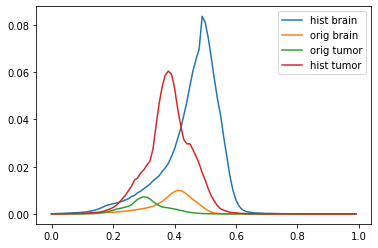

In [1018]:
plt.plot(bins,hist_brain_dataframe.iloc[0], label = 'hist brain')
plt.plot(bins,orig_brain_dataframe.iloc[0], label = 'orig brain')
plt.plot(bins,orig_tumor_dataframe.iloc[0], label = 'orig tumor')
plt.plot(bins,hist_tumor_dataframe.iloc[0], label = 'hist tumor')
plt.legend();

In [1005]:
def make_tumor_hist(hist_img, tumor_mask):
    tumor_mask = tumor_mask.numpy() > 0
    tumor_hist_normed = scaler_min_max(hist_img[:,:,:,0][tumor_mask])
    return np.histogram(tumor_hist_normed, bins = 100)[0]

def make_brain_hist(hist_img, tumor_mask, brain_mask):
    tumor_mask = tumor_mask.numpy() > 0
    brain_hist = hist_img[:,:,:,0]*(~tumor_mask)
    brain_hist = brain_hist*brain_mask.numpy()                  
    brain_hist_normed = scaler_min_max(brain_hist[brain_hist > 0])
    return np.histogram(brain_hist_normed, bins = 100)[0]

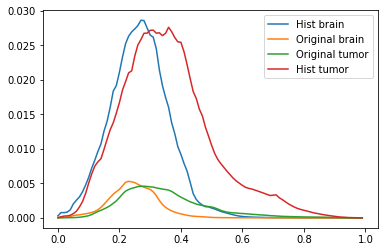

In [1019]:
plt.plot(hist_brain_dataframe.columns, hist_brain_dataframe.mean(), label = 'Hist brain')
plt.plot(hist_brain_dataframe.columns, orig_brain_dataframe.mean(), label = 'Original brain')
plt.plot(hist_brain_dataframe.columns, orig_tumor_dataframe.mean(), label = 'Original tumor')
plt.plot(hist_brain_dataframe.columns, hist_tumor_dataframe.mean(), label = 'Hist tumor')
plt.legend();

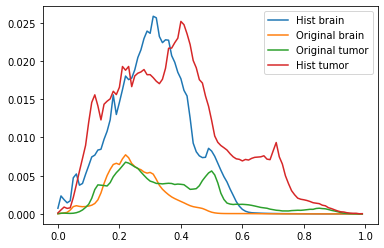

In [1020]:
plt.plot(hist_brain_dataframe.columns, hist_brain_dataframe.std(), label = 'Hist brain')
plt.plot(hist_brain_dataframe.columns, orig_brain_dataframe.std(), label = 'Original brain')
plt.plot(hist_brain_dataframe.columns, orig_tumor_dataframe.std(), label = 'Original tumor')
plt.plot(hist_brain_dataframe.columns, hist_tumor_dataframe.std(), label = 'Hist tumor')
plt.legend();

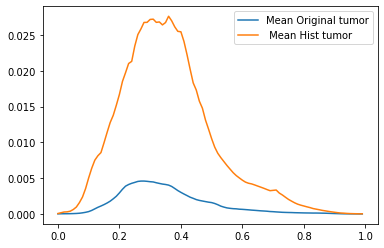

In [1022]:
plt.plot(hist_brain_dataframe.columns, orig_tumor_dataframe.mean(), label = 'Mean Original tumor')
plt.plot(hist_brain_dataframe.columns, hist_tumor_dataframe.mean(), label = ' Mean Hist tumor')
# plt.plot(hist_brain_dataframe.columns, orig_tumor_dataframe.std(), label = 'STD Original tumor')
# plt.plot(hist_brain_dataframe.columns, hist_tumor_dataframe.std(), label = 'STD Hist tumor')
plt.legend();

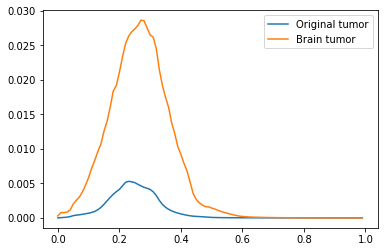

In [1023]:
plt.plot(hist_brain_dataframe.columns, orig_brain_dataframe.mean(), label = 'Original tumor')
plt.plot(hist_brain_dataframe.columns, hist_brain_dataframe.mean(), label = 'Brain tumor')
# plt.plot(hist_brain_dataframe.columns, orig_brain_dataframe.std(), label = 'Original tumor')
# plt.plot(hist_brain_dataframe.columns, hist_brain_dataframe.std(), label = 'Hist tumor')
plt.legend();